In [2]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# 맑은 고딕 적용
plt.rc('font', family='Malgun Gothic')
# 음수 표시
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

# 데이터 구성:Series, DataFrame
import pandas as pd
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# 데이터 시각화:추세, 산점도 행렬
import seaborn as sns
# Scale 변환:평균,표준편차 기준
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split

# 회귀분석
import statsmodels.formula.api as smf
# Decision Tree
from sklearn.tree import DecisionTreeRegressor
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
# 평가 함수
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report
# 분류 Decision Tree
from sklearn.tree import DecisionTreeClassifier
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 주성분 분석
from sklearn.decomposition import PCA
# 회귀분석
import statsmodels.api as sm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# 잔차의 정규성 확인 :qqplot, 회귀분석의 상수항 추가 : add_constant
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
df = pd.read_csv(r"C:\Users\ariml\Downloads\01 실습파일\2. Big Data 분석\SCALE불량.csv", encoding='euc-kr')

# ⓐ 데이터 기초 전처리
- `plate_no`, `rolling_date`, `spec_long` 열 제거
- 목표변수 `scale` 라벨링(0, 1)
- 파생변수 `surface` 생성
- 파생변수 `fur_position` = `fur_no`+`fur_input_row` 생성

In [323]:
df.drop(columns=['plate_no', 'rolling_date', 'spec_long'], inplace=True)
df['scale'] = np.where(df["scale"]=='불량', 1, 0)
df['surface'] = 2 * (df['pt_width'] * df['pt_length'] + df['pt_length'] * df['pt_thick'] + df['pt_thick'] * df['pt_width'])
df['fur_position'] = df['fur_no'].astype(str) + '_' + df['fur_input_row'].astype(str)
# df['steel_kind_label'] = np.where(df['steel_kind']=='T', 0, 1)
# df['hsb_label'] = np.where(df['hsb']=='적용', 1, 0)

In [4]:
df.columns

Index(['plate_no', 'rolling_date', 'scale', 'spec_long', 'spec_country',
       'steel_kind', 'pt_thick', 'pt_width', 'pt_length', 'hsb', 'fur_no',
       'fur_input_row', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp',
       'fur_soak_time', 'fur_total_time', 'rolling_method', 'rolling_temp',
       'descaling_count', 'work_group'],
      dtype='object')

In [5]:
df.groupby('scale').describe()

pt_thick                                                       pt_width  \
         count       mean        std   min    25%   50%   75%    max    count   
scale                                                                           
불량       310.0  24.129032  13.438682  12.0  17.25  20.0  25.0  100.0    310.0   
양품       690.0  27.973913  19.783866  12.0  14.00  18.0  40.0   90.0    690.0   

                    ... rolling_temp         descaling_count           \
              mean  ...          75%     max           count     mean   
scale               ...                                                 
불량     2692.258065  ...       1022.0  1078.0           310.0  8.46129   
양품     2894.637681  ...        961.0  1000.0           690.0  8.60000   

                                             
            std  min  25%   50%   75%   max  
scale                                        
불량     1.349860  5.0  8.0   8.0  10.0  10.0  
양품     1.705281  6.0  6.0  10.0  10.0  10.0  

[2 rows x 80 columns]

In [324]:
# encoder = OneHotEncoder(sparse_output=False)
# encoded_array = encoder.fit_transform(df[['spec_country']])
# encoded_cols = encoder.get_feature_names_out(['spec_country'])
# encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index, dtype=int)
# df = df.join(encoded_df)

# encoded_array = encoder.fit_transform(df[['fur_no']])
# encoded_cols = encoder.get_feature_names_out(['fur_no'])
# encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index, dtype=int)
# df = df.join(encoded_df)

# encoded_array = encoder.fit_transform(df[['fur_input_row']])
# encoded_cols = encoder.get_feature_names_out(['fur_input_row'])
# encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index, dtype=int)
# df = df.join(encoded_df)

In [325]:
df.reset_index(inplace=True, drop=True)

# ⓑ 이상치 처리
- `fur_heat_time` -> 중앙값으로 대체
- `rolling_temp` -> surface 유사값으로 대체

In [326]:
# # fur_heat_time 이상치 확인1
# plt.figure(figsize=(5, 5))
# sns.boxplot(y='fur_heat_time', data=df)
# plt.show()

# # rolling_temp 이상치 확인
# plt.figure(figsize=(3, 3))
# sns.boxplot(y='rolling_temp', data=df)
# plt.show()

In [327]:
Q1 = df['fur_heat_time'].quantile(0.25)
Q3 = df['fur_heat_time'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['fur_heat_time'] < lower_bound) | (df['fur_heat_time'] > upper_bound)]

# print(outliers['fur_heat_time'])
# print("fur_heat_time의 중앙값:", df['fur_heat_time'].median())

df.loc[outliers.index, 'fur_heat_time'] = df['fur_heat_time'].median()
df.loc[outliers.index, 'fur_heat_time'] # 중앙값 대체 확인하기

567    75
676    75
677    75
678    75
679    75
680    75
699    75
700    75
701    75
703    75
Name: fur_heat_time, dtype: int64

In [328]:
outlier_rolling_temp_cols = df[df['rolling_temp']==0]['surface']
# print(outlier_rolling_temp_cols.index)
# print(outlier_rolling_temp_cols.values)

df.loc[53, 'rolling_temp'] = 863
df.loc[[221, 222], 'rolling_temp'] = 999
df.loc[598, 'rolling_temp'] = 842
df.loc[599, 'rolling_temp'] = 876
df.loc[600, 'rolling_temp']= 995 # df[(df['pt_thick'] == 40) & (df['pt_width'] == 2500) & (df['pt_length'] == 23200)]['rolling_temp']

# ⓒ 데이터 시각화

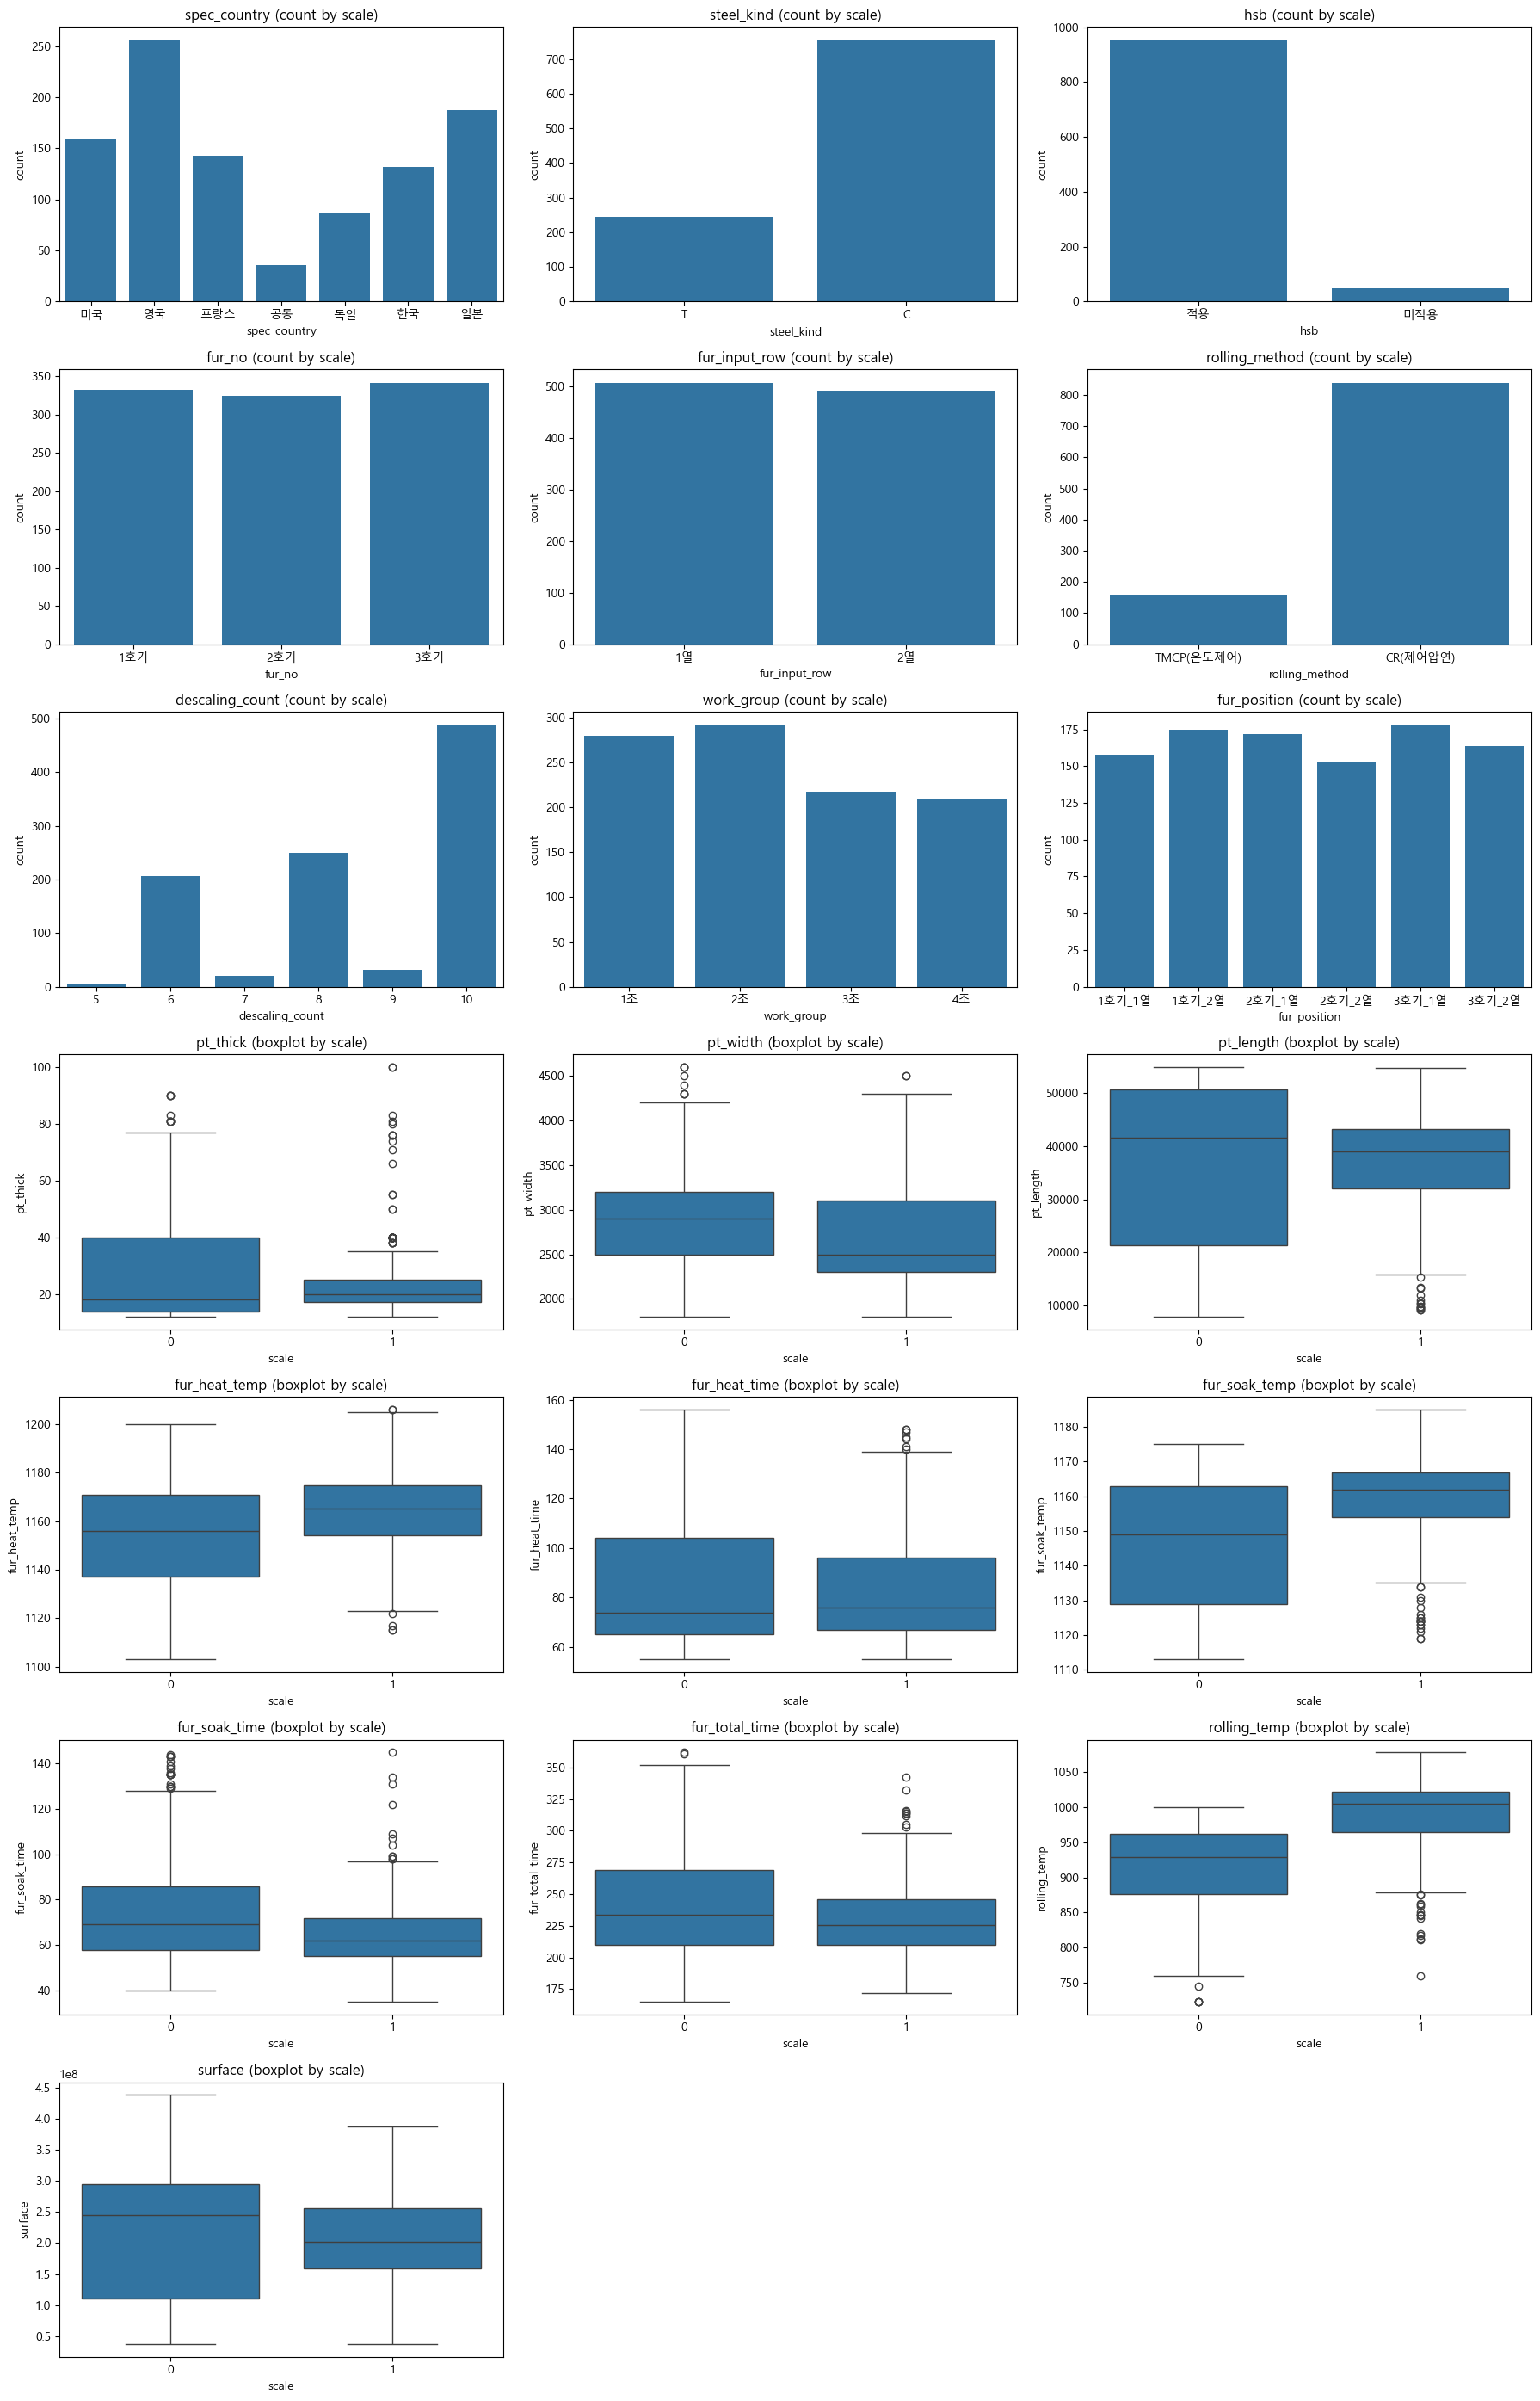

In [329]:
# 데이터 불러오기 -> 기초전처리 첫번째까지만 하고 실행하는 거 추천
target = 'scale'
exclude = [target] 
cat_cols = [col for col in df.columns if (df[col].dtype == 'object' or df[col].nunique() <= 10) and col not in exclude]
num_cols = [col for col in df.columns if df[col].dtype != 'object' and df[col].nunique() > 10 and col not in exclude]

all_cols = cat_cols + num_cols
n_cols = 3
n_rows = (len(all_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, col in enumerate(all_cols):
    plt.subplot(n_rows, n_cols, i+1)
    
    if col in cat_cols:
        sns.countplot(data=df, x=col)
        plt.title(f'{col} (count by scale)')
        
    elif col in num_cols:
        sns.boxplot(data=df, x=target, y=col)
        plt.title(f'{col} (boxplot by scale)')
        
plt.tight_layout()
plt.show()

In [330]:
df.corr(numeric_only=True)

,scale,pt_thick,pt_width,pt_length,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,surface
scale,1.000000,-0.098090,-0.189536,0.052115,0.222493,-0.022430,0.327817,-0.219581,-0.127695,0.509490,-0.040011,-0.045329
pt_thick,-0.098090,1.000000,-0.319894,-0.867125,-0.525317,0.230825,-0.665964,0.357260,0.338078,-0.454413,-0.845324,-0.844566
pt_width,-0.189536,-0.319894,1.000000,0.147979,0.200737,-0.112564,0.216879,-0.097273,-0.133329,-0.155074,0.350132,0.488808
pt_length,0.052115,-0.867125,0.147979,1.000000,0.470846,-0.168918,0.603303,-0.333730,-0.276402,0.369636,0.818483,0.924765
fur_heat_temp,0.222493,-0.525317,0.200737,0.470846,1.000000,-0.167785,0.787203,-0.373154,-0.313632,0.342497,0.488292,0.468792
fur_heat_time,-0.022430,0.230825,-0.112564,-0.168918,-0.167785,1.000000,-0.353652,0.098450,0.689373,-0.133408,-0.192533,-0.170217
fur_soak_temp,0.327817,-0.665964,0.216879,0.603303,0.787203,-0.353652,1.000000,-0.596820,-0.560808,0.627961,0.627843,0.575347
fur_soak_time,-0.219581,0.357260,-0.097273,-0.333730,-0.373154,0.098450,-0.596820,1.000000,0.632995,-0.484010,-0.399353,-0.301228
fur_total_time,-0.127695,0.338078,-0.133329,-0.276402,-0.313632,0.689373,-0.560808,0.632995,1.000000,-0.343562,-0.339263,-0.262667
rolling_temp,0.509490,-0.454413,-0.155074,0.369636,0.342497,-0.133408,0.627961,-0.484010,-0.343562,1.000000,0.316979,0.223144


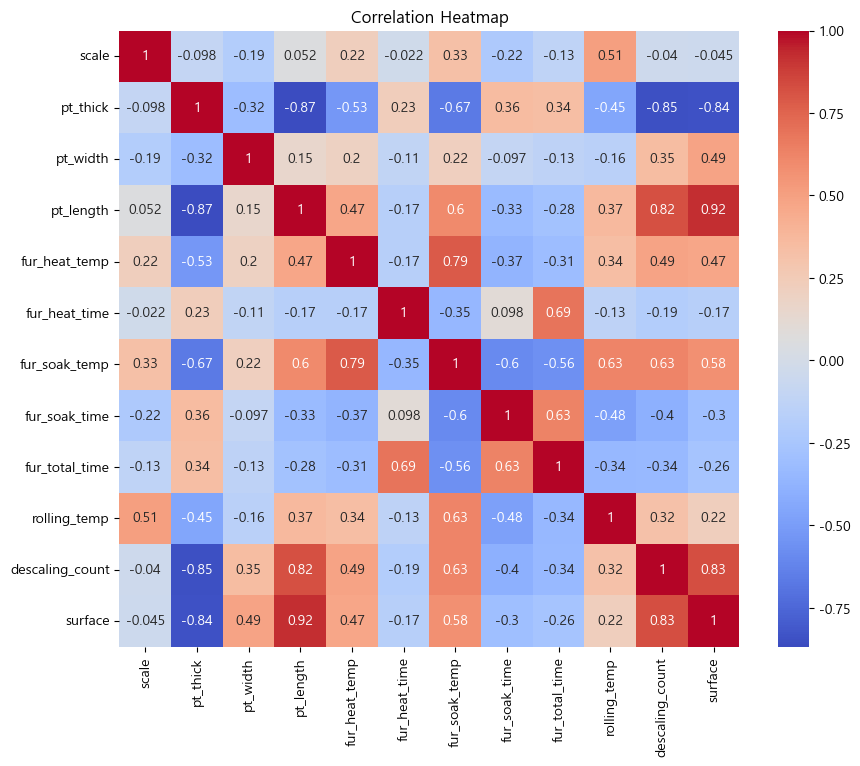

In [331]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# ⓓ 탐색적 분석
- 1. C / T 
- 2. Spec_contry 
- 3. pt_thick width length 
- 4. surface 
- 5. HSB
- 6. fur_position 
- 7. fur_heat_temp
- 8. fur_heat_time
- 9. fur_soak_temp
- 10. fur_soak_time
- 11. fur_total_time
- 12. rolling_method
- 13. rolling_temp
- 14. descaling_count
- 15. work_group

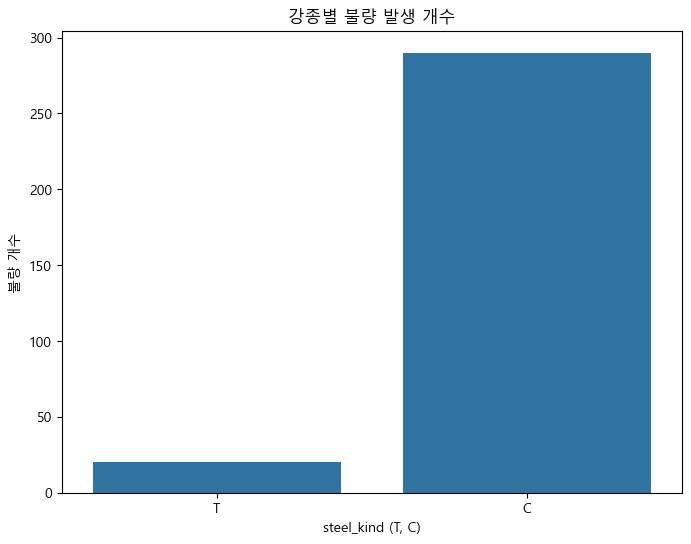

In [332]:
#1. 강종  T ( 티타늄 )  / C ( 카본 )
df_defect = df[df['scale'] == 1]

plt.figure(figsize=(8, 6))
sns.countplot(x='steel_kind', data=df_defect)

plt.title('강종별 불량 발생 개수')
plt.xlabel('steel_kind (T, C)')
plt.ylabel('불량 개수')
plt.show()

C강종이 T강종보다 스케일 불량이 약 3배 더 많이 발생함.

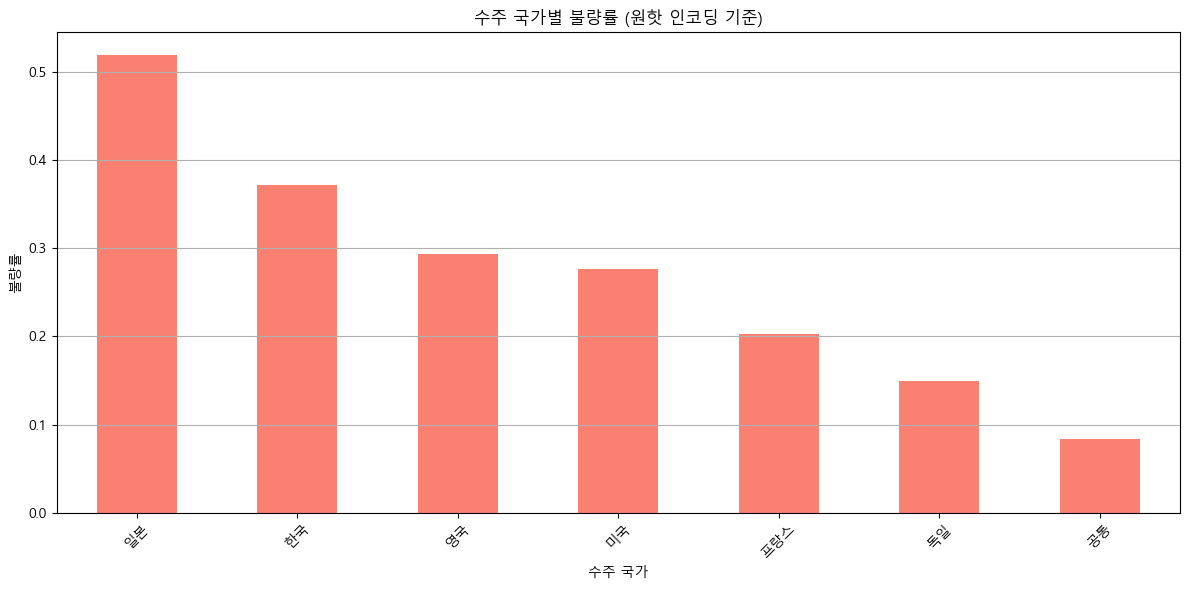

In [333]:
df_dummy = pd.get_dummies(df)
country_cols = [col for col in df_dummy.columns if col.startswith('spec_country_')]

defect_rates = {}
for col in country_cols:
    country_df = df_dummy[df_dummy[col] == 1]
    defect_rate = country_df['scale'].mean()
    defect_rates[col.replace('spec_country_', '')] = defect_rate

defect_rates_series = pd.Series(defect_rates).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
defect_rates_series.plot(kind='bar', color='salmon')

plt.title('수주 국가별 불량률 (원핫 인코딩 기준)')
plt.ylabel('불량률')
plt.xlabel('수주 국가')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

일본, 한국, 영국 순으로 스케일 불량률이 높으며, 공통은 가장 낮은 불량률을 보임.

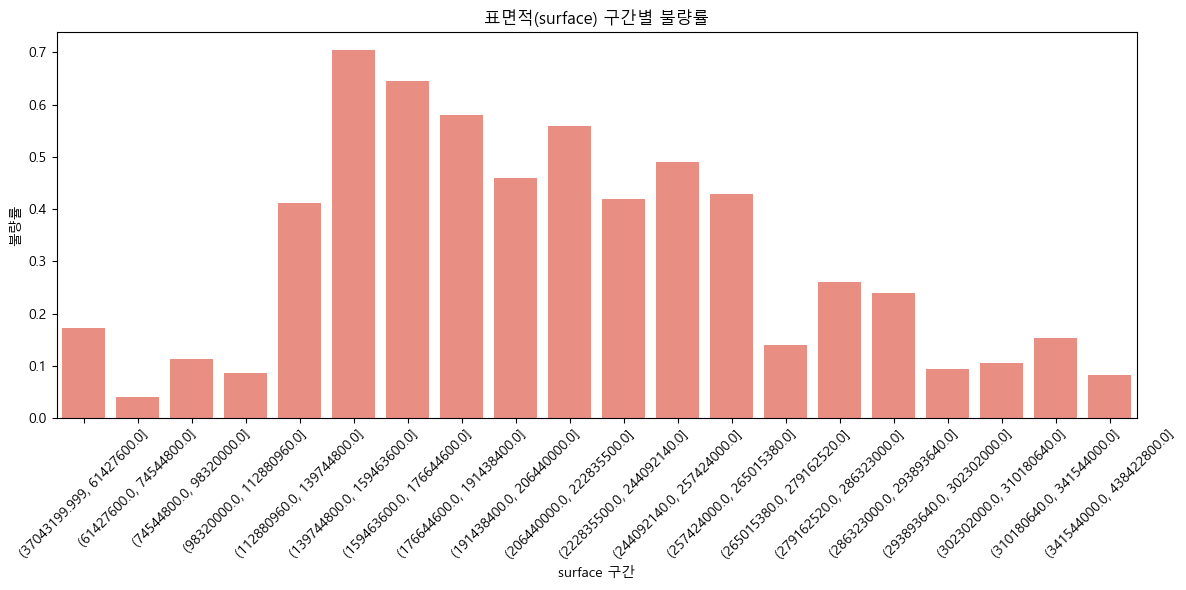

In [334]:
copy_df = df.copy()
copy_df['surface_bin'] = pd.qcut(df['surface'], q=20)

bin_defect_rate = copy_df.groupby('surface_bin')['scale'].mean()
bin_counts = copy_df['surface_bin'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=bin_defect_rate.index.astype(str), y=bin_defect_rate.values, color='salmon')

plt.title('표면적(surface) 구간별 불량률')
plt.xlabel('surface 구간')
plt.ylabel('불량률')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

표면적이 약 1500만~2200만 구간에서 스케일 불량률이 가장 높게 나타남.
즉 표면적이 높다해서 불량률이 높은것이 아님 

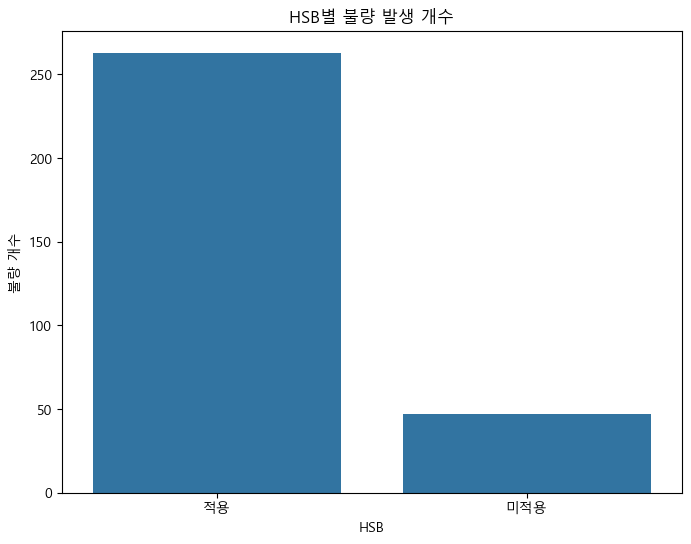

In [335]:
plt.figure(figsize=(8, 6))
sns.countplot(x='hsb', data=df_defect)

plt.title('HSB별 불량 발생 개수')
plt.xlabel('HSB')
plt.ylabel('불량 개수')
plt.show()

HSB 적용 그룹(1)에서 불량 발생 개수가 비적용 그룹(0)보다 현저히 많음.

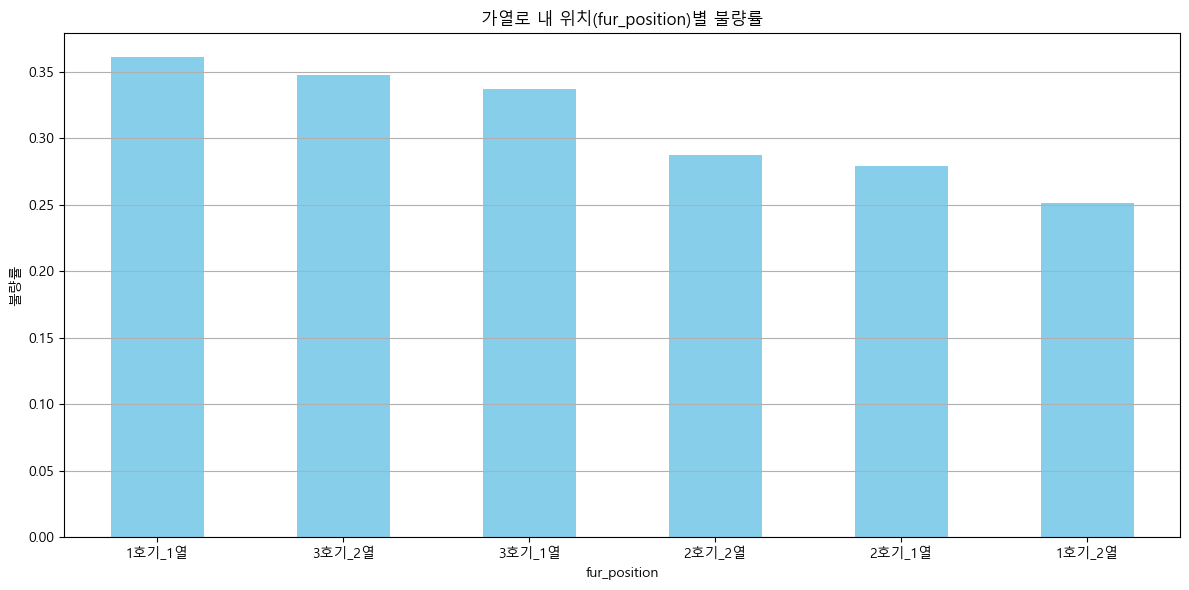

In [336]:
position_cols = [col for col in df_dummy.columns if col.startswith('fur_position_')]

defect_rates = {}
for col in position_cols:
    position_df = df_dummy[df_dummy[col] == 1]
    defect_rate = position_df['scale'].mean()
    defect_rates[col.replace('fur_position_', '')] = defect_rate

defect_rates_series = pd.Series(defect_rates).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
defect_rates_series.plot(kind='bar', color='skyblue')

plt.title('가열로 내 위치(fur_position)별 불량률')
plt.ylabel('불량률')
plt.xlabel('fur_position')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

가열로 위치(fur_position)가 1조1열일수록 불량률이 가장 높고, 1조2열에서 가장 낮음.

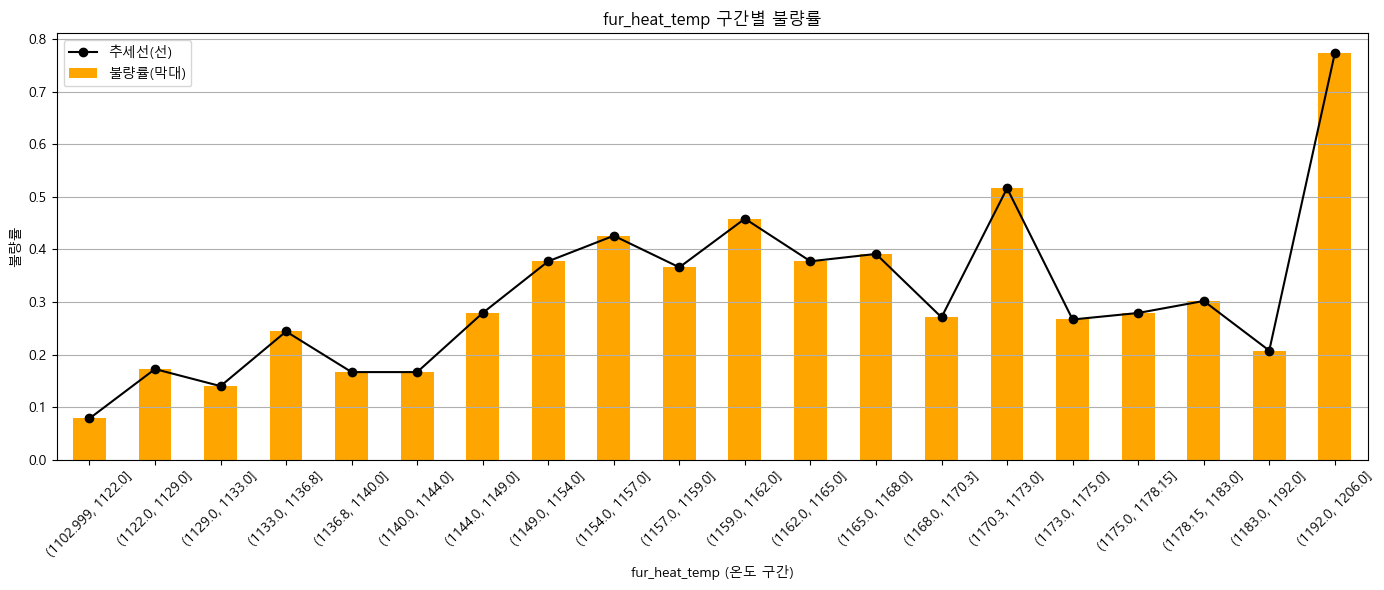

In [337]:
copy_df['heat_bin'] = pd.qcut(df['fur_heat_temp'], q=20)

heat_defect_rate = copy_df.groupby('heat_bin')['scale'].mean()

plt.figure(figsize=(14, 6))
ax = heat_defect_rate.plot(kind='bar', color='orange', label='불량률(막대)')
heat_defect_rate.plot(marker='o', color='black', label='추세선(선)', ax=ax)

plt.title('fur_heat_temp 구간별 불량률')
plt.xlabel('fur_heat_temp (온도 구간)')
plt.ylabel('불량률')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

fur_heat_temp가 1760도 이상일 때 불량률이 급격히 증가함.

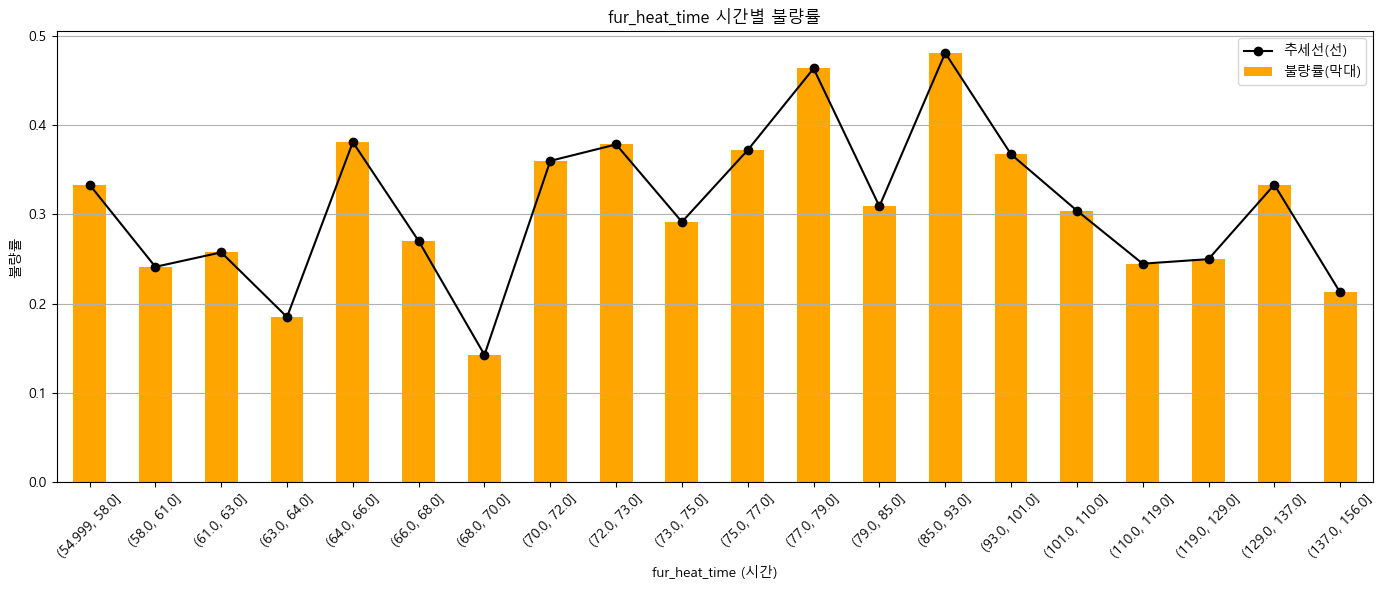

In [338]:
copy_df['time_bin'] = pd.qcut(df['fur_heat_time'], q=20)

heat_defect_rate = copy_df.groupby('time_bin')['scale'].mean()


plt.figure(figsize=(14, 6))
ax = heat_defect_rate.plot(kind='bar', color='orange', label='불량률(막대)')
heat_defect_rate.plot(marker='o', color='black', label='추세선(선)', ax=ax)

plt.title('fur_heat_time 시간별 불량률')
plt.xlabel('fur_heat_time (시간)')
plt.ylabel('불량률')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

fur_heat_time이 약 70~100분 구간에서 불량률이 상대적으로 높게 나타남.

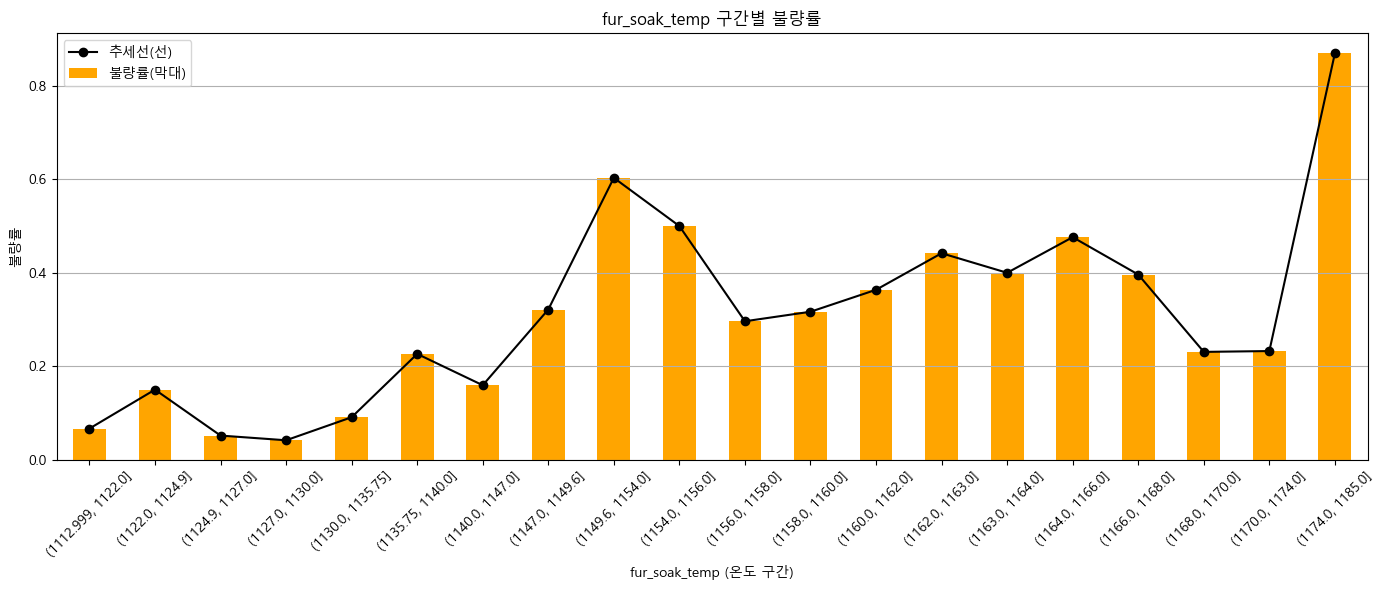

In [339]:
copy_df['heat_bin'] = pd.qcut(df['fur_soak_temp'], q=20)
heat_defect_rate = copy_df.groupby('heat_bin')['scale'].mean()

plt.figure(figsize=(14, 6))
ax = heat_defect_rate.plot(kind='bar', color='orange', label='불량률(막대)')
heat_defect_rate.plot(marker='o', color='black', label='추세선(선)', ax=ax)

plt.title('fur_soak_temp 구간별 불량률')
plt.xlabel('fur_soak_temp (온도 구간)')
plt.ylabel('불량률')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

fur_soak_temp이 약 1530 ~ 1540도 및 1740 ~ 1850도 구간에서 불량률이 급격히 상승함.

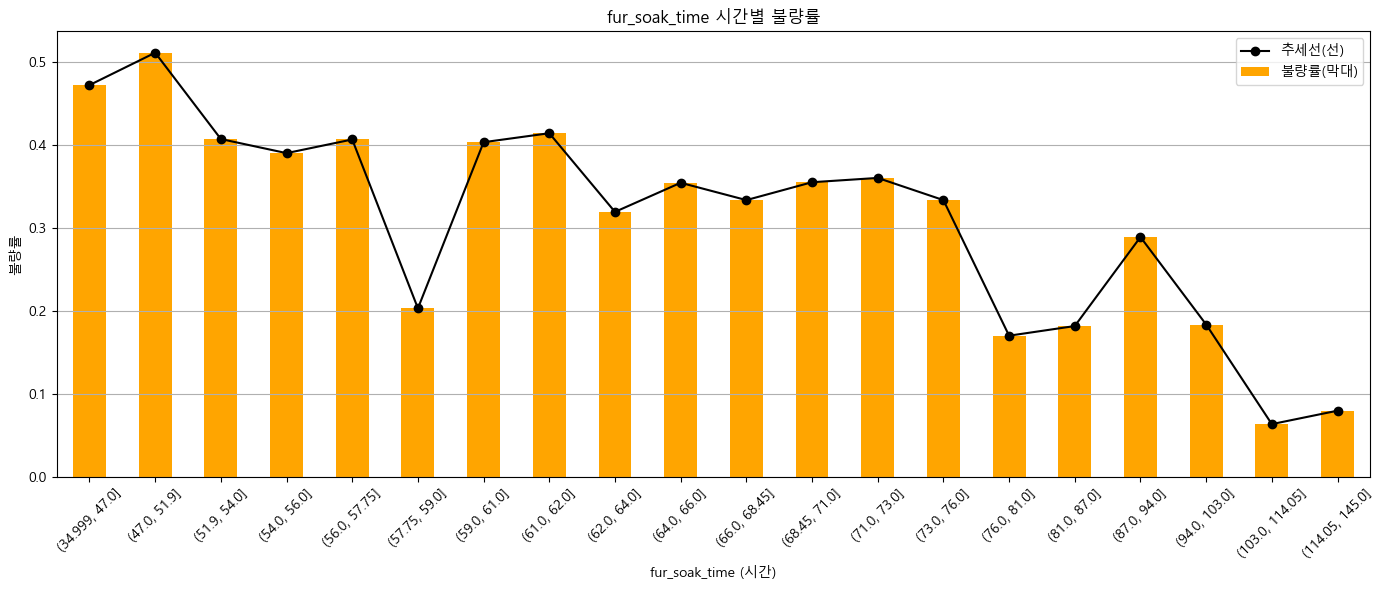

In [340]:
copy_df['time_bin'] = pd.qcut(df['fur_soak_time'], q=20)
heat_defect_rate = copy_df.groupby('time_bin')['scale'].mean()

plt.figure(figsize=(14, 6))
ax = heat_defect_rate.plot(kind='bar', color='orange', label='불량률(막대)')
heat_defect_rate.plot(marker='o', color='black', label='추세선(선)', ax=ax)

plt.title('fur_soak_time 시간별 불량률')
plt.xlabel('fur_soak_time (시간)')
plt.ylabel('불량률')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

fur_soak_time이 47시간 이하일 때와 70시간 전후에서 불량률이 상대적으로 높게 나타남.

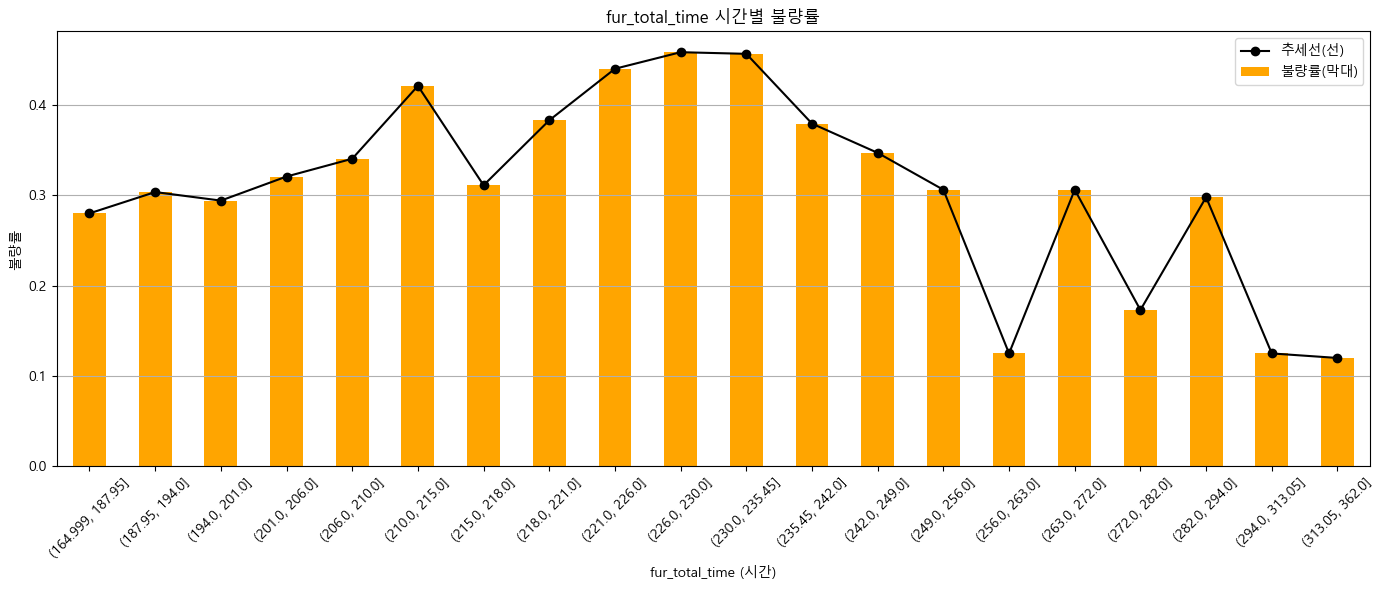

In [341]:
copy_df['totaltime_bin'] = pd.qcut(df['fur_total_time'], q=20)
heat_defect_rate = copy_df.groupby('totaltime_bin')['scale'].mean()

plt.figure(figsize=(14, 6))
ax = heat_defect_rate.plot(kind='bar', color='orange', label='불량률(막대)')
heat_defect_rate.plot(marker='o', color='black', label='추세선(선)', ax=ax)

plt.title('fur_total_time 시간별 불량률')
plt.xlabel('fur_total_time (시간)')
plt.ylabel('불량률')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

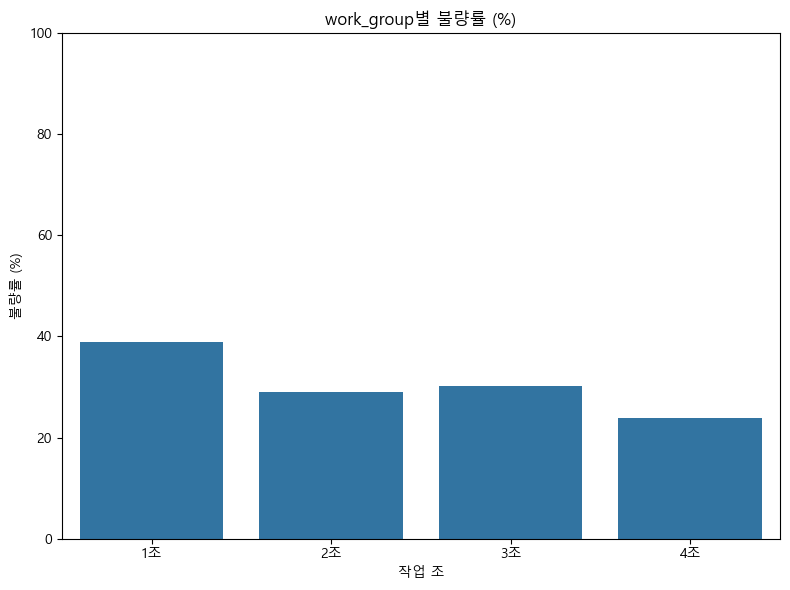

In [342]:
group_defect_rate = df.groupby('work_group')['scale'].mean() * 100

plt.figure(figsize=(8, 6))
sns.barplot(x=group_defect_rate.index, y=group_defect_rate.values)

plt.title('work_group별 불량률 (%)')
plt.xlabel('작업 조')
plt.ylabel('불량률 (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

1조에서 불량률이 가장 높으며, 4조에서 가장 낮게 나타남.

**경향성 분석**

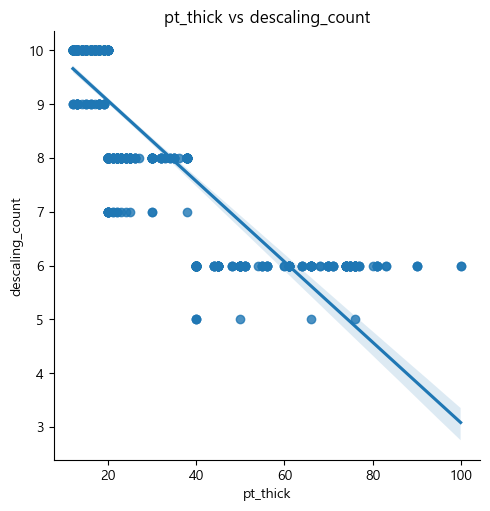

In [343]:
# 1. pt_thick vs descailing count 

sns.lmplot(data=df, x='pt_thick', y='descaling_count')
plt.title('pt_thick vs descaling_count')
plt.show()

- 두꺼운 후판은 열전달이 느리다 → 표면 산화 억제
- 두꺼운 강판은 내부까지 열이 천천히 전달됨.
- 표면이 급격히 가열되지 않기 때문에 산화 반응이 상대적으로 느리게 진행됨
---------------
- 반대로, 얇은 강판은 열이 빠르게 전달되어 표면 온도가 빨리 상승 → 스케일(산화철) 형성 활발.

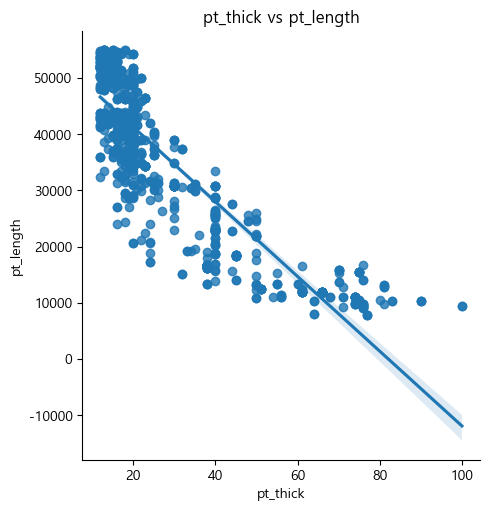

In [344]:
# 2 . thick vs length
sns.lmplot(data=df, x='pt_thick', y='pt_length')
plt.title('pt_thick vs pt_length')
plt.xlabel('pt_thick')
plt.ylabel('pt_length')
plt.show()

- 선이 우하향이면 → 두꺼울수록 오히려 길이가 짧다는 경향
- 목표 두께가 두꺼우면 애초에 압연(Rolling) 횟수(Pass 수)가 적게 들어감 <br/>
=> 그렇기 때문에 길이가 짧아짐.

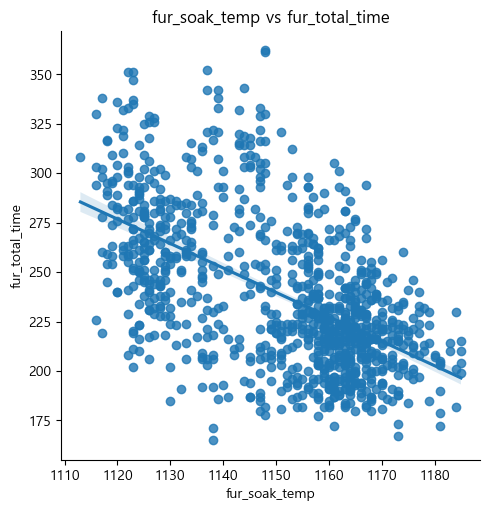

In [345]:
# 3 . soak_temp vs total_time
sns.lmplot(data=df, x='fur_soak_temp', y='fur_total_time')
plt.title('fur_soak_temp vs fur_total_time')
plt.xlabel('fur_soak_temp')
plt.ylabel('fur_total_time')
plt.show()

균열대 소재 온도가 높아질수록 소재 목표 온도에 빨리 도달하게 되기 때문에, 이로 인해 전체 시간은 줄어들게 된다

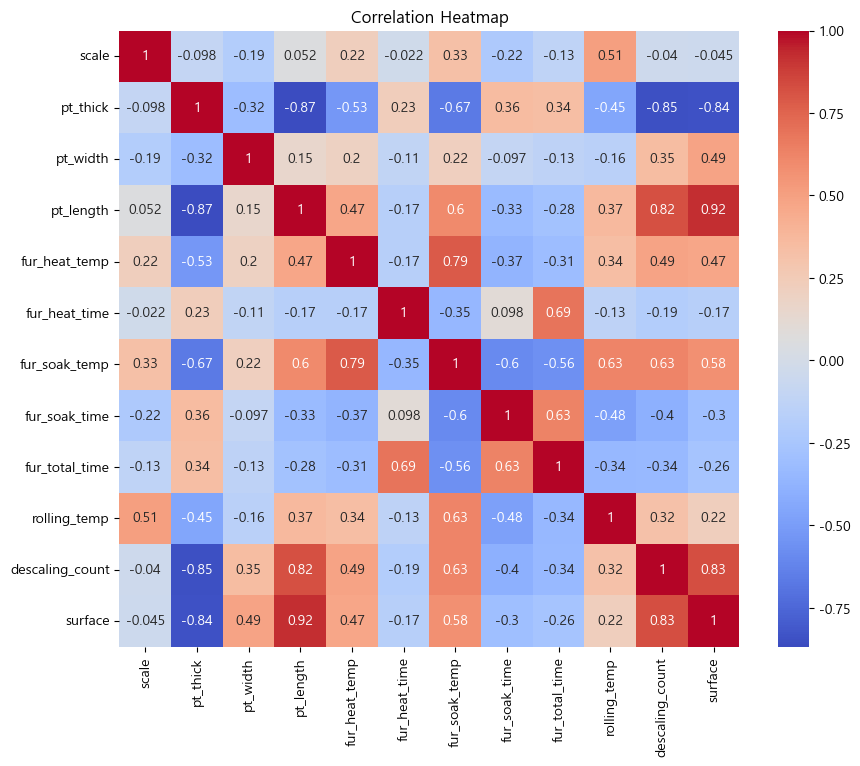

In [346]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**surface** 중심 분석

 | 변수          |  상관계수     | 해석                                       |
| ----------- | ---------- | ---------------------------------------- |
| `pt_length` | **0.92** | 후판 길이가 길수록 표면적 증가함 (기하학적으로 당연)           |
| `pt_thick`  | -0.84    | 두께가 두꺼울수록 표면적이 줄어드는 경향 (폭·길이와 반비례하는 경향성) |
| `pt_width`  | **0.49** | 폭이 넓을수록 표면적 증가                           |

**fur_heat_temp** 중심 분석
| 변수                | 상관계수     | 해석                                     |
| ----------------- | -------- | -------------------------------------- |
| `fur_soak_temp`   | **0.79** | 균열대 온도가 높을수록 가열대 온도도 높다 (당연한 연속 공정 흐름) |
| `pt_thick`        | -0.53    | 두께가 클수록 가열 온도 낮아짐 (두꺼운 재료는 더 천천히 가열)   |
| `descaling_count` | **0.63** | 온도가 높을수록 디스케일링 횟수도 증가 (스케일 생성 방지 시도)  |
| `surface`         | **0.47** | 표면적 클수록 더 높은 온도에서 가열되는 경향              |

**descaling_count** 중심 분석
| 변수          | 상관계수     | 해석                                 |
| ----------- | -------- | ---------------------------------- |
| `surface`   | **0.83** | 표면적이 클수록 더 많이 디스케일링함               |
| `pt_length` | **0.49** | 길이가 길수록 descaling 증가               |
| `pt_thick`  | -0.85    | 두꺼울수록 적게 함 (얇은 제품일수록 더 스케일 발생 위험 감소 ) |

**rolling_temp** 중심 분석
| 변수                | 상관계수     | 해석                           |
| ----------------- | -------- | ---------------------------- |
| `descaling_count` | **0.32** | 압연 온도가 높을수록 스케일 제거 많아짐 경향    |
| `fur_soak_temp`   | **0.63** | 가열→압연까지 온도 흐름 유지됨            |
| `fur_total_time`  | 0.34     | 가열로 체류시간이 길수록 압연 온도도 높아지는 경향 |

[결론: 이 히트맵에서 알 수 있는 것]
- 표면적이 클수록 불량 관련 요인(높은 온도, 높은 descaling_count)에 연결됨

- 두께(pt_thick)는 대부분 음의 상관관계
→ 두꺼울수록 열 전달이 느리고 descaling이 적게 일어남

- fur_heat_temp는 공정 온도 흐름(soak, rolling 등)에 강한 영향

- descaling_count는 스케일 방지와 매우 밀접 → 핵심 변수 후보

### 가설 설정

1. 가열대 온도가 높을 수록 Scale 증가 
2. 철 종류에 따라 Scale 증가 
3. Surface가 클수록 descailing 증가 
4.  특정 작업조(work_group)에 따라 스케일 불량률에 차이가 있다.

In [347]:
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

In [348]:
# 1. fur_heat_temp(가열대 온도)가 높을 수록 Scale 증가 (피어슨 상관분석 (Pearson correlation))
#귀무가설 (H₀): fur_heat_temp(가열대 온도)와 scale 사이에는 상관관계가 없다.
#대립가설 (H₁): fur_heat_temp가 높을수록 scale이 증가하는 경향이 있다.
r, p = pearsonr(df['fur_heat_temp'], df['scale'])

print(f"피어슨 상관계수: {r:.3f}")
print(f"p-value: {p:.4f}")

피어슨 상관계수: 0.222
p-value: 0.0000


[분석 결과]

- 상관계수 r = 0.222 → 약한 양(+)의 상관관계
- p-value ≈ 0.0000 → 유의수준 0.05에서 귀무가설 기각

[해석]

- 가열대 온도(fur_heat_temp)와 scale 간에는 유의미한 양의 상관관계가 존재하며,
- 가열대 온도가 높을수록 scale이 다소 증가하는 경향이 있음.

In [349]:
# 2. steel_kind(철 종류)에 따라 Scale 증가  ( 카이제곱 검정 (Chi-square test))
#귀무가설(H₀): 철 종류(steel_kind)와 Scale은 관련이 없다 (독립이다).
#대립가설(H₁): 철 종류와 Scale은 관련이 있다 (독립이 아니다).
contingency_table = pd.crosstab(df['steel_kind'], df['scale'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square 통계량:", round(chi2, 3))
print("p-value:", round(p, 4))
print("자유도:", dof)

Chi-square 통계량: 77.71
p-value: 0.0
자유도: 1


[해석]

- 유의수준 0.05에서 p-value < 0.05이므로 귀무가설 기각 <br/>
→ 철 종류에 따라 Scale의 분포가 유의하게 다르다고 할 수 있음.

In [350]:
# 3. surface가 클수록 descaling 증가 ( 피어슨 상관계수 검정: 두 연속형 변수 간 상관관계)
#귀무가설(H₀): surface와 descaling_count는 상관이 없다.
#대립가설(H₁): surface가 클수록 descaling_count가 증가한다 (양의 상관관계).
# 상관계수 및 p-value 계산
r, p = pearsonr(df['surface'], df['descaling_count'])

print(f"피어슨 상관계수: {r:.3f}")
print(f"p-value: {p:.4f}")

피어슨 상관계수: 0.831
p-value: 0.0000


[해석]

- surface와 descaling_count 간에는 매우 강한 양의 상관관계가 있으며 (r = 0.831), p-value < 0.05이므로 귀무가설 기각 <br/>

→ 즉, surface가 클수록 descaling 횟수가 증가하는 경향이 통계적으로 유의미함을 확인할 수 있다.

In [351]:
# 4. work_group(특정 작업조)에 따라 스케일 불량률에 차이가 있다 ( 카이제곱 검정 )
#귀무가설(H₀): 작업조(work_group)에 따라 스케일 불량률의 차이는 없다.
#대립가설(H₁): 작업조에 따라 스케일 불량률에 차이가 있다.
contingency_table = pd.crosstab(df['work_group'], df['scale'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 결과 출력
print("Chi-square 통계량:", round(chi2, 3))
print("p-value:", round(p, 4))
print("자유도:", dof)

Chi-square 통계량: 13.846
p-value: 0.0031
자유도: 3


[해석]

- 작업조에 따라 스케일 불량률이 통계적으로 유의미하게 다른지 확인하기 위해 카이제곱 검정을 실시
    
- 검정 결과, p-value = 0.0031 < 0.05로 나타나 귀무가설을 기각할 수 있으며,이는 작업조에 따라 스케일 불량률에 유의미한 차이가 존재함을 의미

# ⓔ 모델링

In [352]:
df_train, df_test = train_test_split(df,
                                     test_size = 0.3, 
                                     random_state = 1234)

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (700, 20)
test data size : (300, 20)


In [353]:
df.columns

Index(['scale', 'spec_country', 'steel_kind', 'pt_thick', 'pt_width',
       'pt_length', 'hsb', 'fur_no', 'fur_input_row', 'fur_heat_temp',
       'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time',
       'rolling_method', 'rolling_temp', 'descaling_count', 'work_group',
       'surface', 'fur_position'],
      dtype='object')

### 로지스틱 회귀분석

In [354]:
from statsmodels.api import Logit

In [355]:
log_model = Logit.from_formula('''
scale ~ C(spec_country) + C(steel_kind) + pt_thick + pt_width + pt_length +
         C(hsb) + C(fur_no) + C(fur_input_row) + fur_heat_temp + fur_heat_time +
         fur_soak_temp + fur_soak_time + fur_total_time + C(rolling_method) +
         rolling_temp + descaling_count + C(work_group) + surface''', df_train)
log_result = log_model.fit()

print(log_result.summary())

         Current function value: 0.294519
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  700
Model:                          Logit   Df Residuals:                      673
Method:                           MLE   Df Model:                           26
Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                  0.5234
Time:                        19:10:14   Log-Likelihood:                -206.16
converged:                      False   LL-Null:                       -432.57
Covariance Type:            nonrobust   LLR p-value:                 1.887e-79
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         -24.5918   7.75e+05  -3.18e-05      1.000   -1.52e+06    1.52e+06
C(

#### ✅ 로지스틱 회귀분석 최종모델

In [356]:
log_model = Logit.from_formula('''
scale ~ fur_heat_temp + fur_heat_time + rolling_temp + descaling_count''', df_train)
log_result = log_model.fit()

print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.408978
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  scale   No. Observations:                  700
Model:                          Logit   Df Residuals:                      695
Method:                           MLE   Df Model:                            4
Date:                Tue, 15 Jul 2025   Pseudo R-squ.:                  0.3382
Time:                        19:10:14   Log-Likelihood:                -286.28
converged:                       True   LL-Null:                       -432.57
Covariance Type:            nonrobust   LLR p-value:                 4.350e-62
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -63.6528      7.690     -8.278      0.000     -78.725     -48.581
fur_heat_temp 

In [357]:
y_pred_train = log_result.predict(df_train)
y_pred_train_class = (y_pred_train > 0.5).astype(int)
print("Train 예측 결과 \n", y_pred_train_class.head(), "\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["scale"],y_pred_train_class)),"\n")

y_pred_test = log_result.predict(df_test)
y_pred_test_class = (y_pred_test > 0.5).astype(int)
print("Test 예측 결과 \n", y_pred_test_class.head(),"\n")
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["scale"],y_pred_test_class)),"\n")

Train 예측 결과 
 96     0
792    0
218    0
967    0
170    1
dtype: int32 

Confusion Matrix: 
[[440  44]
 [ 77 139]] 

Test 예측 결과 
 681    0
990    1
155    1
768    0
438    0
dtype: int32 

Confusion Matrix: 
[[188  18]
 [ 35  59]] 



In [358]:
print("Train 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_train["scale"], y_pred_train_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_train["scale"],y_pred_train_class)),"\n")
print(classification_report(df_train["scale"], y_pred_train_class, digits=3))

print("Test 예측/분류 결과")
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["scale"], y_pred_test_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["scale"],y_pred_test_class)),"\n")
print(classification_report(df_test["scale"], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.827

Confusion Matrix: 
[[440  44]
 [ 77 139]] 

              precision    recall  f1-score   support

           0      0.851     0.909     0.879       484
           1      0.760     0.644     0.697       216

    accuracy                          0.827       700
   macro avg      0.805     0.776     0.788       700
weighted avg      0.823     0.827     0.823       700

Test 예측/분류 결과
Accuracy: 0.823

Confusion Matrix: 
[[188  18]
 [ 35  59]] 

              precision    recall  f1-score   support

           0      0.843     0.913     0.876       206
           1      0.766     0.628     0.690        94

    accuracy                          0.823       300
   macro avg      0.805     0.770     0.783       300
weighted avg      0.819     0.823     0.818       300



<Axes: >

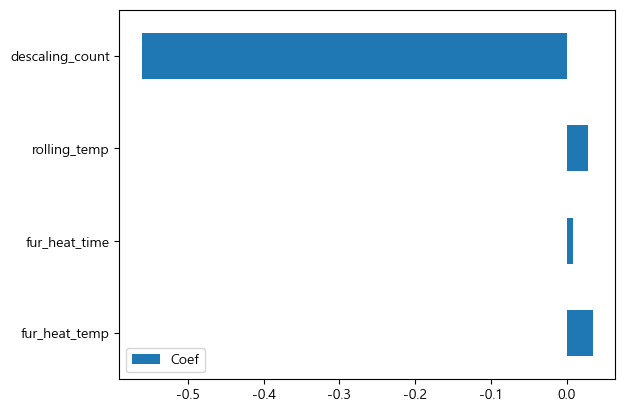

In [359]:
# 설명변수 중요도
df_logistic_coef = pd.DataFrame({"Coef": log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = "Coef")

### 의사결정나무

In [360]:
df_raw_dummy = pd.get_dummies(df)
df_raw_dummy.head()

df_raw_x = df_raw_dummy.drop("scale", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["scale"]


df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234) 

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (1000, 39)
분할 후 설명변수 데이터 :Train (700, 39)   Test (300, 39)


In [361]:
df

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,surface,fur_position
0,0,미국,T,32,3700,15100,적용,1호기,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조,112943200,1호기_1열
1,0,미국,T,32,3700,15100,적용,1호기,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조,112943200,1호기_2열
2,0,영국,T,33,3600,19200,적용,2호기,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조,139744800,2호기_1열
3,0,영국,T,33,3600,19200,적용,2호기,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조,139744800,2호기_2열
4,0,프랑스,T,38,3100,13300,적용,3호기,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조,83706400,3호기_1열
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,프랑스,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,203,CR(제어압연),948,10,4조,283906200,1호기_2열
996,0,영국,C,19,3400,41500,적용,1호기,2열,1142,55,1151,86,209,CR(제어압연),948,10,4조,283906200,1호기_2열
997,0,미국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,227,CR(제어압연),948,10,4조,298761400,2호기_2열
998,0,영국,C,17,3400,43700,적용,2호기,2열,1169,65,1163,77,204,CR(제어압연),948,10,4조,298761400,2호기_2열


In [362]:
v_feature_name = df_train_x.columns

In [363]:
from imblearn.over_sampling import SMOTE

# Over-sampling 설정

sm = SMOTE(sampling_strategy='auto', random_state=1234)

# train데이터를 이용한 Over-sampling
x_resampled, y_resampled = sm.fit_resample(df_train_x,df_train_y)

# 결과 확인
print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
print('Over-Sampling 후 Train Y: {} \n'.format(y_resampled.shape))

print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전:
 scale
0    484
1    216
Name: count, dtype: int64 

Over-Sampling 후 Train X: (968, 39)
Over-Sampling 후 Train Y: (968,) 

Over-Sampling 후 '1':484
Over-Sampling 후 '0':484


,Depth,TrainAccuracy,TestAccuracy
0,3,0.957,0.967
1,4,0.966,0.967
2,5,0.966,0.967
3,6,0.989,0.993
4,7,0.989,0.993
5,8,0.993,0.993
6,9,0.999,0.993
7,10,1.000,0.983
8,11,1.000,0.983


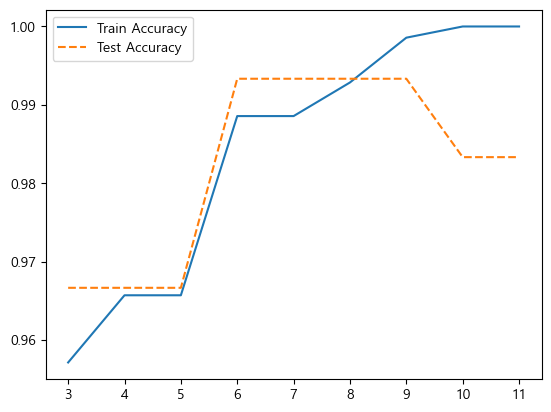

In [364]:
train_accuracy = []; test_accuracy = []
para_depth = [depth for depth in range(3, 12)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
display(df_accuracy_depth.round(3))

plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()
plt.show()

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.989,0.993
1,30,0.989,0.993
2,40,0.989,0.993
3,50,0.989,0.993
4,60,0.989,0.993
5,70,0.989,0.993
6,80,0.989,0.993
7,90,0.989,0.993
8,100,0.989,0.993
9,110,0.989,0.993


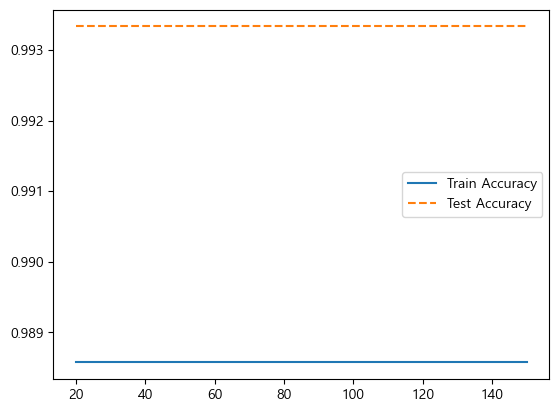

In [365]:
train_accuracy = []; test_accuracy = []
para_split = [n_split * 10 for n_split in range(2, 16)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth=6, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
display(df_accuracy_split.round(3))

plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()
plt.show()

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.980,0.993
1,12,0.980,0.993
2,14,0.980,0.993
3,16,0.980,0.993
4,18,0.969,0.967
5,20,0.969,0.967
6,22,0.969,0.967
7,24,0.966,0.953
8,26,0.957,0.967
9,28,0.921,0.883


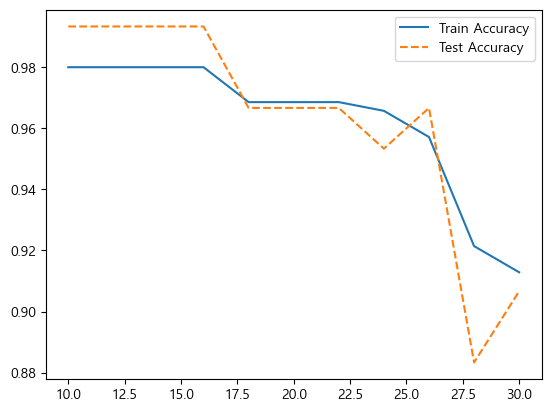

In [366]:
train_accuracy = []; test_accuracy = [] 
para_leaf = [n_leaf * 2 for n_leaf in range(5,16)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf = v_min_samples_leaf, \
		max_depth=6, random_state=1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))

df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
display(df_accuracy_leaf.round(3))

plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.legend()
plt.show()

#### ✅ 의사결정나무 최종모델

In [367]:
tree_final = DecisionTreeClassifier(max_depth=6, min_samples_leaf=12, random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=12, random_state=1234)

In [368]:
y_pred = tree_final.predict(df_test_x)
print("Train Accuracy: {0:.3f}\n".format(tree_final.score(df_train_x, df_train_y)))
print("Test Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.980

Test Accuracy: 0.993

Test Confusion matrix: 
[[206   0]
 [  2  92]]
              precision    recall  f1-score   support

           0      0.990     1.000     0.995       206
           1      1.000     0.979     0.989        94

    accuracy                          0.993       300
   macro avg      0.995     0.989     0.992       300
weighted avg      0.993     0.993     0.993       300



In [369]:
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
8,rolling_temp,0.573
21,hsb_적용,0.160
5,fur_soak_temp,0.151
9,descaling_count,0.110
2,pt_length,0.006
30,work_group_2조,0.000
23,fur_no_2호기,0.000
24,fur_no_3호기,0.000
25,fur_input_row_1열,0.000
26,fur_input_row_2열,0.000


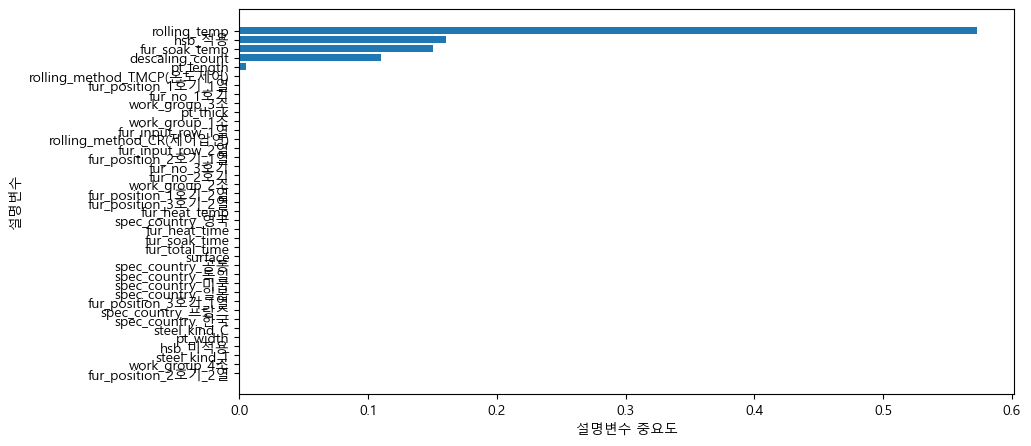

In [370]:
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))

plt.figure(figsize=(10,5))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")
plt.show()

### 랜덤포레스트

In [371]:
from sklearn.ensemble import RandomForestClassifier

df_raw_dummy = pd.get_dummies(df)
df_raw_dummy.head()

df_raw_x = df_raw_dummy.drop(columns=['scale'], axis = 1, inplace = False)
df_raw_y = df_raw_dummy["scale"]

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (1000, 39)
분할 후 설명변수 데이터 :Train (700, 39)   Test (300, 39)


,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.993,0.963
1,20,0.999,0.963
2,30,1.000,0.967
3,40,1.000,0.967
4,50,1.000,0.967
5,60,1.000,0.967
6,70,1.000,0.967
7,80,1.000,0.967
8,90,1.000,0.967
9,100,1.000,0.967


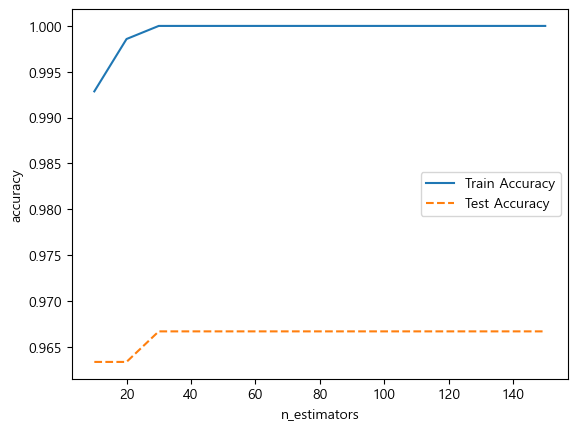

In [372]:
train_accuracy = []; test_accuracy = []
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators = v_n_estimators, random_state = 1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy
display(df_accuracy_n.round(3))

plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("n_estimators"); plt.ylabel("accuracy")
plt.legend()
plt.show()

,Depth,TrainAccuracy,TestAccuracy
0,3,0.926,0.937
1,4,0.940,0.937
2,5,0.951,0.953
3,6,0.966,0.963
4,7,0.976,0.950
5,8,0.977,0.963
6,9,0.987,0.967
7,10,0.984,0.970
8,11,0.994,0.967
9,12,0.996,0.960


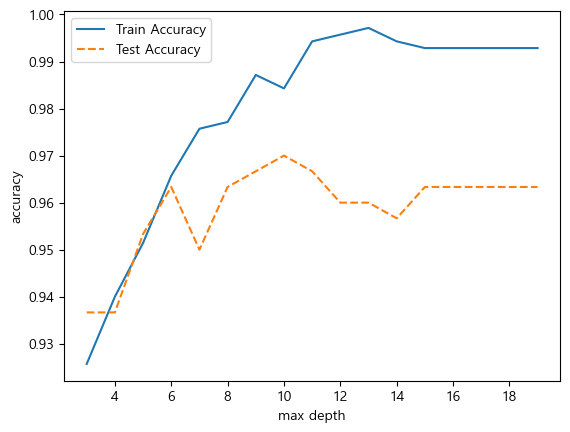

In [373]:
train_accuracy = []; test_accuracy = []
# max_depth: 최대 깊이 변경
para_depth = [depth for depth in range(3, 20)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(max_depth = v_max_depth, n_estimators=10, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
display(df_accuracy_depth.round(3))

plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("max depth"); plt.ylabel("accuracy")
plt.legend()
plt.show()

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.974,0.967
1,20,0.961,0.967
2,30,0.960,0.957
3,40,0.947,0.953
4,50,0.951,0.953
5,60,0.951,0.950
6,70,0.949,0.960
7,80,0.954,0.963
8,90,0.956,0.963
9,100,0.949,0.963


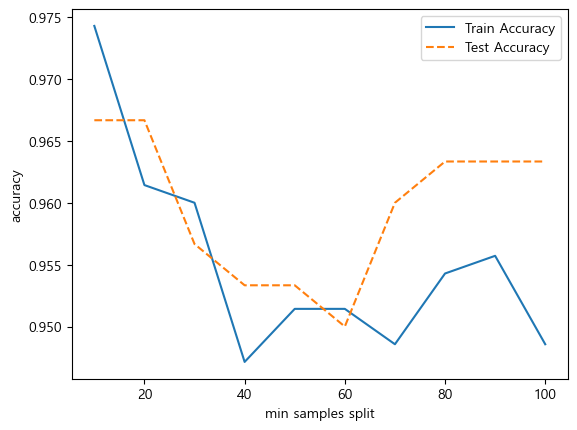

In [374]:
train_accuracy = []; test_accuracy = []
# min_samples_split: 분할하기 위한 노드의 최소 샘플 수.
para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(min_samples_split = v_min_samples_split, max_depth=10,
                                n_estimators=10, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
display(df_accuracy_split.round(3))

plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples split"); plt.ylabel("accuracy")
plt.legend()
plt.show()

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.947,0.950
1,10,0.936,0.930
2,15,0.901,0.900
3,20,0.880,0.867
4,25,0.874,0.867
5,30,0.876,0.860
6,35,0.874,0.857
7,40,0.876,0.867
8,45,0.876,0.867
9,50,0.876,0.867


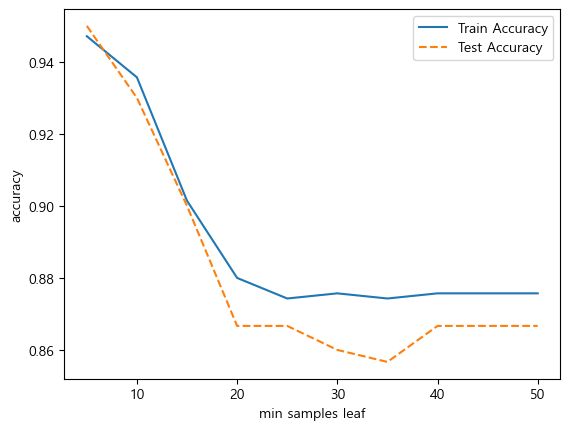

In [375]:
train_accuracy = []; test_accuracy = []
# min_samples_leaf: 잎사귀 수 제한
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(min_samples_leaf = v_min_samples_leaf, min_samples_split=20,
                                max_depth=10, n_estimators=10, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
display(df_accuracy_leaf.round(3))

plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("min samples leaf"); plt.ylabel("accuracy")
plt.legend()
plt.show()

#### ✅ 랜덤포레스트 최종모델

In [376]:
rf_final = RandomForestClassifier(min_samples_leaf=5, max_depth=10, n_estimators=10, min_samples_split=20,
                                  random_state=1234)
rf_final.fit(df_train_x, df_train_y)
# 평가
y_pred = rf_final.predict(df_test_x)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))

# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 0.947
Accuracy on test set: 0.950

Confusion matrix: 
[[205   1]
 [ 14  80]]
              precision    recall  f1-score   support

           0      0.936     0.995     0.965       206
           1      0.988     0.851     0.914        94

    accuracy                          0.950       300
   macro avg      0.962     0.923     0.939       300
weighted avg      0.952     0.950     0.949       300



In [377]:
# 변수명
v_feature_names = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_names
df_importance ["Importance"] = rf_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
8,rolling_temp,0.313
5,fur_soak_temp,0.094
9,descaling_count,0.082
1,pt_width,0.075
0,pt_thick,0.067
3,fur_heat_temp,0.051
20,hsb_미적용,0.045
21,hsb_적용,0.042
2,pt_length,0.042
6,fur_soak_time,0.028


Text(0, 0.5, '설명변수')

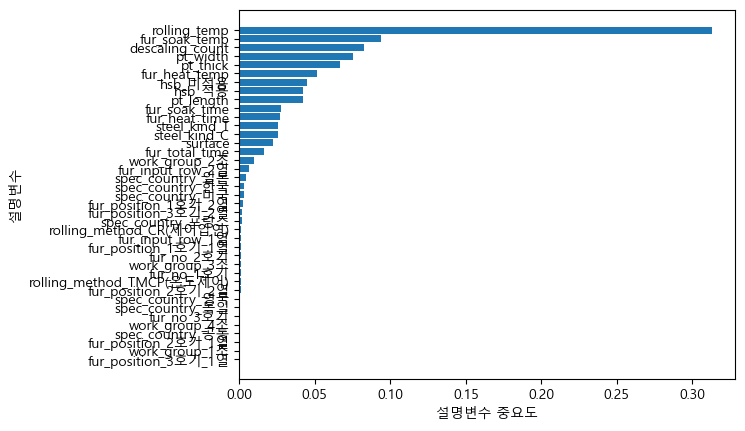

In [378]:
df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### 그래디언트 부스팅

,LearningRate,TrainAccuracy,TestAccuracy
0,0.02,0.965714,0.966667
1,0.04,0.978571,0.970000
2,0.06,1.000000,0.990000
3,0.08,1.000000,0.996667
4,0.10,1.000000,0.996667
5,0.12,1.000000,0.996667
6,0.14,1.000000,0.996667
7,0.16,1.000000,0.996667
8,0.18,1.000000,0.996667
9,0.20,1.000000,0.996667


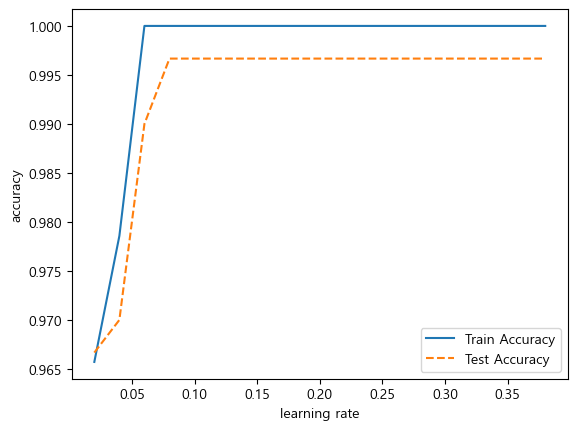

In [379]:
train_accuracy = []; test_accuracy = []
para_lr = [lr * 0.02 for lr in range(1, 20)]   # train set 과적합으로 0.02 간격 확인

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_lr = pd.DataFrame()
df_accuracy_lr
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy
display(df_accuracy_lr)

plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()
plt.show()

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.957,0.967
1,20,0.957,0.967
2,30,0.957,0.967
3,40,0.966,0.967
4,50,0.966,0.967
5,60,0.966,0.967
6,70,0.966,0.967
7,80,0.967,0.967
8,90,0.969,0.967
9,100,0.979,0.970


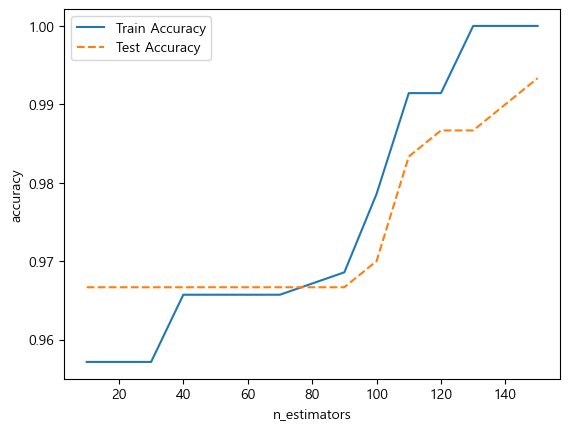

In [380]:
train_accuracy = []; test_accuracy = []
para_n_tree = [n_tree * 10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate=0.04, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy
display(df_accuracy_n.round(3))

plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()
plt.show()

,Depth,TrainAccuracy,TestAccuracy
0,1,0.957,0.967
1,2,0.966,0.967
2,3,0.991,0.987
3,4,1.000,0.993
4,5,1.000,0.997
5,6,1.000,0.997
6,7,1.000,0.997
7,8,1.000,0.987
8,9,1.000,0.993
9,10,1.000,0.990


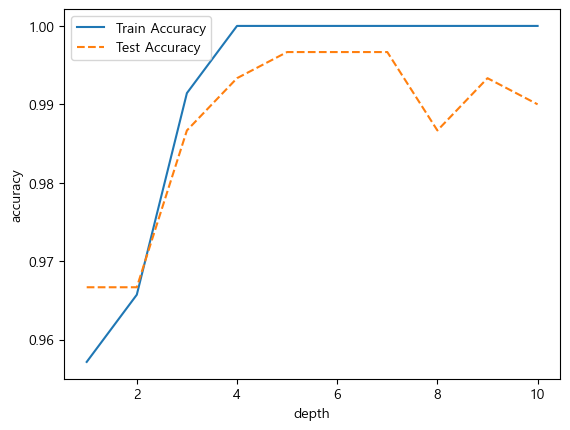

In [381]:
train_accuracy = []; test_accuracy = []
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth,
                            n_estimators=120, learning_rate=0.04, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
display(df_accuracy_depth.round(3))

plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()
plt.show()

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,4,0.991,0.987
1,6,0.991,0.987
2,8,0.991,0.987
3,10,0.991,0.987
4,12,0.999,0.987
5,14,0.999,0.987
6,16,0.999,0.987
7,18,0.999,0.987
8,20,0.997,0.990
9,22,0.993,0.990


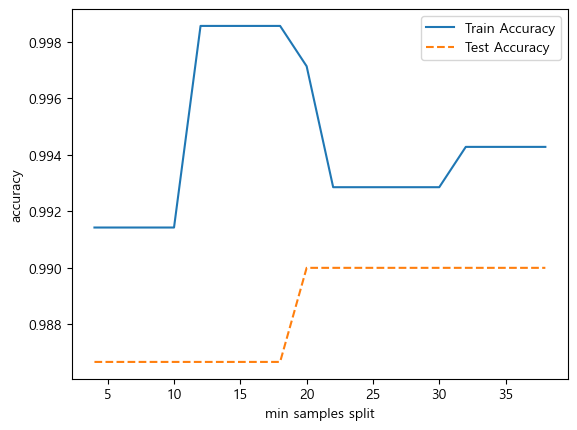

In [382]:
train_accuracy = []; test_accuracy = []
para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split,
                                    max_depth=3, n_estimators=120, learning_rate=0.04, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
display(df_accuracy_split.round(3))

plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples split")
plt.legend()
plt.show()

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.999,0.990
1,10,0.991,0.993
2,15,0.991,0.997
3,20,0.990,0.987
4,25,0.987,0.983
5,30,0.944,0.920
6,35,0.947,0.907
7,40,0.941,0.893
8,45,0.936,0.903
9,50,0.934,0.900


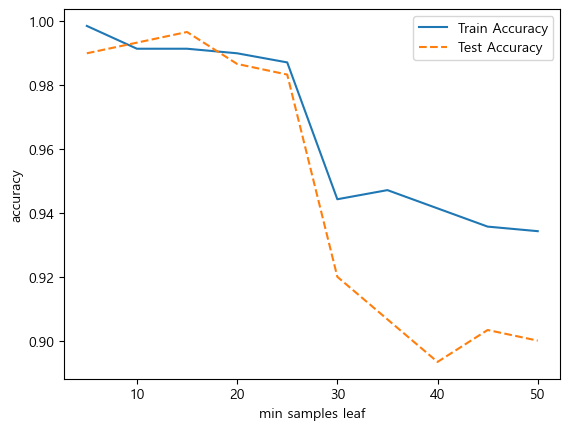

In [383]:
train_accuracy = []; test_accuracy = []
para_leaf = [n_leaf * 5 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf,
                                     max_depth=3, n_estimators=120, learning_rate=0.04, min_samples_split=10, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
display(df_accuracy_leaf.round(3))

plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()
plt.show()

#### ✅ 그래디언트부스팅 최종모델

In [384]:
# 최종 모델
gb_final = GradientBoostingClassifier(min_samples_leaf=15, min_samples_split=10, max_depth=3, n_estimators=120, learning_rate=0.04,
                                      random_state=1234)
gb_final.fit(df_train_x, df_train_y)

y_pred = gb_final.predict(df_test_x)

print("Train Accuracy: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Test Accuracy: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.991
Test Accuracy: 0.997

Test Confusion matrix: 
[[206   0]
 [  1  93]]
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           1      1.000     0.989     0.995        94

    accuracy                          0.997       300
   macro avg      0.998     0.995     0.996       300
weighted avg      0.997     0.997     0.997       300



,Feature,Importance
8,rolling_temp,0.577
5,fur_soak_temp,0.153
21,hsb_적용,0.081
20,hsb_미적용,0.078
0,pt_thick,0.063
9,descaling_count,0.033
10,surface,0.011
3,fur_heat_temp,0.001
2,pt_length,0.001
6,fur_soak_time,0.000


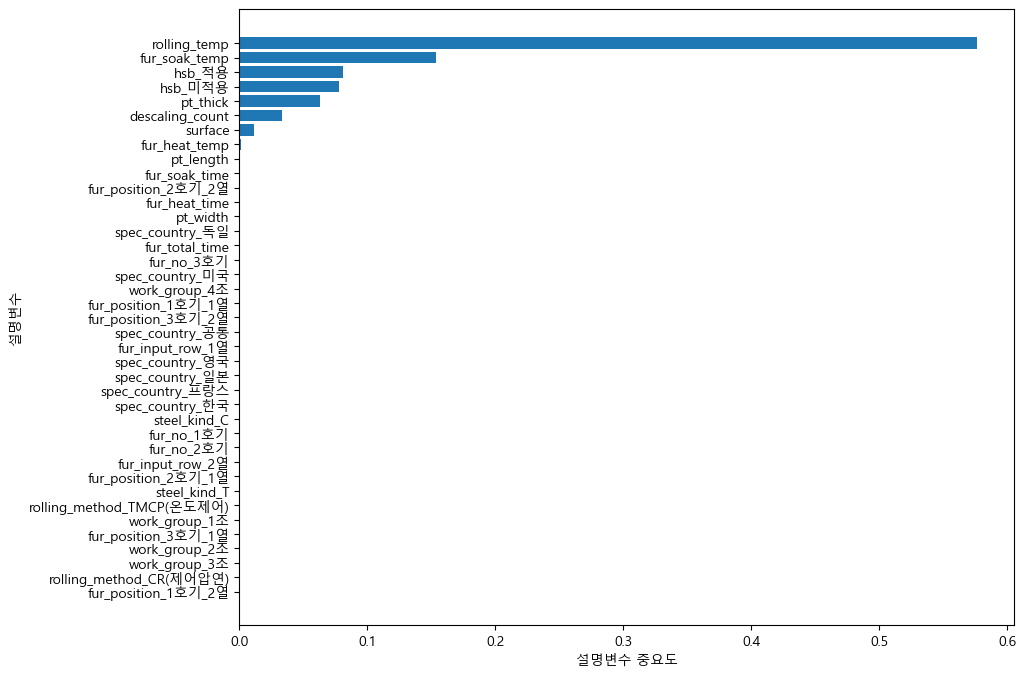

In [385]:
# 설명변수 중요도
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
display(df_importance.round(3))

fig, ax = plt.subplots(figsize=(10, 8))

df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")
plt.show()

### XGBoost

In [386]:
# xgboost 패키지 불러오기
from xgboost import XGBClassifier
# 변수 중요도 확인: F1 점수 기준
from xgboost import plot_importance

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))


In [387]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

estimator = XGBClassifier(random_state=1234)
param_rd = {"max_depth": para_depth, "n_estimators": para_n_tree, "min_samples_split": para_split, "min_samples_leaf": para_leaf, "learning_rate": para_lr}

rd_rf = RandomizedSearchCV(estimator, param_rd, n_iter=50, scoring="accuracy", n_jobs=-1)
rd_rf.fit(df_train_x, df_train_y)
print("best estimator model: \n{}" .format(rd_rf.best_estimator_))
print("\nbest parameter: \n{}" .format(rd_rf.best_params_))
print("\nbest estimator model: \n{}" .format(rd_rf.best_score_.round(3)))

best estimator model: 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, min_samples_leaf=45,
              min_samples_split=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, ...)

best parameter: 
{'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 45, 'max_depth': 8, 'learning_rate': 0.1}

best estimator model: 
0.987


#### ✅ xgboost 최종모델

In [388]:
xgboost_user= XGBClassifier(n_estimators=20, learning_rate=0.22, min_samples_split=4, min_samples_leaf=5, max_depth=8, random_state=1234)
xgboost_user.fit(df_train_x, df_train_y)

print("Train Accucary : {:.3f}".format(xgboost_user.score(df_train_x, df_train_y)))
print("Test Accuracy : {:.3f}\n".format(xgboost_user.score(df_test_x, df_test_y)))

# 예측 및 모델 평가:Train
xgb_pred_train = xgboost_user.predict(df_train_x)
print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, xgb_pred_train)
print('\n',classification_report(df_train_y, xgb_pred_train))

# 예측 및 모델 평가:Test
xgb_pred_test = xgboost_user.predict(df_test_x)
print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))

Train Accucary : 1.000
Test Accuracy : 0.997


 사용자 모델 평가 : Train 

오차행렬:
 [[484   0]
 [  0 216]] 

정확도: 1.0000
정밀도: 1.0000
재현율: 1.0000
F1    : 1.0000
AUC   : 1.0000

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       484
           1       1.00      1.00      1.00       216

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700


 사용자 모델 평가 : Test 

오차행렬:
 [[206   0]
 [  1  93]] 

정확도: 0.9967
정밀도: 1.0000
재현율: 0.9894
F1    : 0.9947
AUC   : 0.9947

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       206
           1       1.00      0.99      0.99        94

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



### LGBM

In [389]:
import sys
print(sys.executable)

C:\Users\ariml\AppData\Local\Programs\Python\Python312\python.exe


In [390]:
# !C:/Users/ariml/AppData/Local/Programs/Python/Python312/python.exe -m pip install lightgbm

#### ✅ lightgbm 최종모델

In [391]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

lightgbm_user= LGBMClassifier(n_estimators=140, learning_rate=0.28, min_samples_split=18, min_samples_leaf=40, max_depth=5, random_state=1234, verbose=-1)
lightgbm_user.fit(df_train_x, df_train_y)

print("Train Accucary : {:.3f}".format(lightgbm_user.score(df_train_x, df_train_y)))
print("Test Accuracy : {:.3f}\n".format(lightgbm_user.score(df_test_x, df_test_y)))

xgb_pred_train = lightgbm_user.predict(df_train_x)
print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, xgb_pred_train)
print('\n',classification_report(df_train_y, xgb_pred_train))

xgb_pred_test = lightgbm_user.predict(df_test_x)
print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, xgb_pred_test)
print('\n',classification_report(df_test_y, xgb_pred_test))

Train Accucary : 1.000
Test Accuracy : 0.913


 사용자 모델 평가 : Train 

오차행렬:
 [[484   0]
 [  0 216]] 

정확도: 1.0000
정밀도: 1.0000
재현율: 1.0000
F1    : 1.0000
AUC   : 1.0000

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       484
           1       1.00      1.00      1.00       216

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700


 사용자 모델 평가 : Test 

오차행렬:
 [[200   6]
 [ 20  74]] 

정확도: 0.9133
정밀도: 0.9250
재현율: 0.7872
F1    : 0.8506
AUC   : 0.8791

               precision    recall  f1-score   support

           0       0.91      0.97      0.94       206
           1       0.93      0.79      0.85        94

    accuracy                           0.91       300
   macro avg       0.92      0.88      0.89       300
weighted avg       0.91      0.91      0.91       300



### SVM

In [392]:
from sklearn.svm import SVC

In [393]:
df_raw_x = df.drop("scale", axis = 1, inplace = False)
df_raw_y = df["scale"] 

# 범주형 변수 선택 : select_dtypes="object" 
df_raw_x_char = df_raw_x.select_dtypes(include = "object")
df_raw_x_char.head()

# get_dummies: 범주형 변수에 대한 더미변환 
df_x_dummy = pd.get_dummies(df_raw_x_char)

# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")
# df_raw_x_num.head()

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

df_x_converted = df_x_scaled.join(df_x_dummy)

In [395]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_converted, df_raw_y
                                    , test_size = 0.3, random_state = 1234)

print("분할된 Train Data: {}".format(df_train_x.shape))
print("분할된 Test Data: {}".format(df_test_x.shape))

분할된 Train Data: (700, 39)
분할된 Test Data: (300, 39)


In [396]:
svm_uncust = SVC(random_state=1234)
svm_uncust.fit(df_train_x, df_train_y)

print("Train Accuracy : {:.3f}".format(svm_uncust.score(df_train_x, df_train_y)))
print("Test Accuracy : {:.3f}".format(svm_uncust.score(df_test_x, df_test_y)))

Train Accuracy : 0.913
Test Accuracy : 0.890


,Cost,TrainAccuracy,TestAccuracy
0,0.1,0.830,0.800
1,0.2,0.849,0.827
2,0.3,0.860,0.840
3,0.4,0.876,0.843
4,0.5,0.884,0.857
5,0.6,0.896,0.867
6,0.7,0.899,0.877
7,0.8,0.907,0.883
8,0.9,0.913,0.890
9,1.0,0.913,0.890


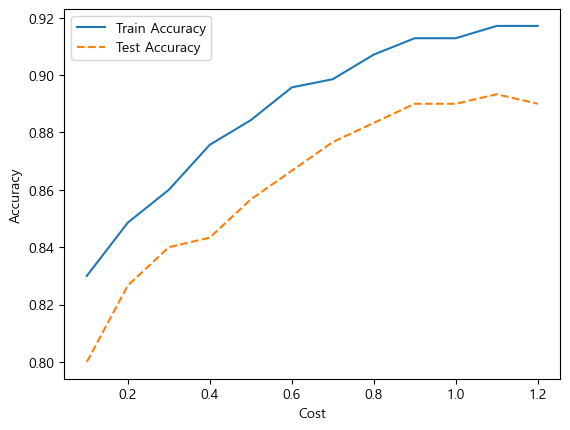

In [397]:
train_accuracy = []; test_accuracy = []

# para_c = [10 **c for c in range(-2, 3)] # 0.01, 0.1, 1, 10, 100 : 큰 변화 영향 확인
para_c = [0.1 * c for c in range(1, 13)]  # 0.1~1.0 : 작은 변화 영향 확인

for v_C in para_c:
    svm = SVC(C = v_C, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

df_accuracy_c = pd.DataFrame()
df_accuracy_c["Cost"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy
display(df_accuracy_c.round(3))

plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Cost")
plt.legend()
plt.show()

,gamma,TrainAccuracy,TestAccuracy
0,0.1,0.9314,0.8900
1,0.2,0.9614,0.8667
2,0.3,0.9757,0.8467
3,0.4,0.9900,0.8267
4,0.5,0.9957,0.7933
5,0.6,0.9986,0.7800
6,0.7,0.9986,0.7467
7,0.8,0.9986,0.7367
8,0.9,0.9986,0.7267
9,1.0,0.9986,0.7267


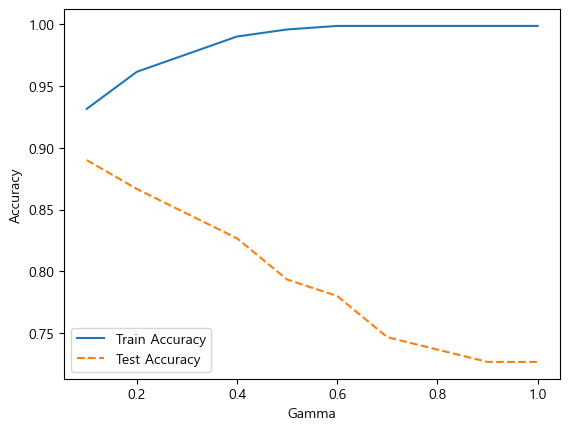

In [398]:
train_accuracy = []; test_accuracy = []

# para_gamma = [10 **gamma for gamma in range(-2, 3)]   # 0.01, 0.1, 1, 10, 100 : 큰 변화 영향 확인
para_gamma = [0.1 * gamma for gamma in range(1, 11)]     # 0.1~1.0 : 작은 변화 영향 확인

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 1.1, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy
display(df_accuracy_gamma.round(4))

plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("Accuracy"); plt.xlabel("Gamma")  # X 축 범위 log 변환
plt.legend()
plt.show()

#### ✅ svm 최종모델

In [399]:
svc_final = SVC(gamma=0.1, C=1.1, random_state=1234)
svc_final.fit(df_train_x, df_train_y)

y_pred = svc_final.predict(df_test_x)

print("Train Accucary : {:.3f}".format(svc_final.score(df_train_x, df_train_y)))
print("Test Accuracy : {:.3f}\n".format(svc_final.score(df_test_x, df_test_y)))
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Train Accucary : 0.931
Test Accuracy : 0.890

Test Confusion matrix: 
[[197   9]
 [ 24  70]]
              precision    recall  f1-score   support

           0      0.891     0.956     0.923       206
           1      0.886     0.745     0.809        94

    accuracy                          0.890       300
   macro avg      0.889     0.850     0.866       300
weighted avg      0.890     0.890     0.887       300



### NN

In [400]:
df_x=df.drop("scale", axis=1, inplace=False)
df_y=df["scale"]

df_x_num=df_x.select_dtypes(include="number")
df_x_cat=df_x.select_dtypes(include="object")

v_features_names=df_x_num.columns

scaler=StandardScaler()
df_x_scaled=scaler.fit_transform(df_x_num)
df_x_scaled=pd.DataFrame(df_x_scaled, columns=v_features_names)

df_x_char=df_x.select_dtypes(include="object")
df_x_dummy=pd.get_dummies(df_x_char)

df_x_converted=df_x_scaled.join(df_x_dummy)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_converted, df_y, test_size=0.3, random_state=1234)

In [403]:
from sklearn.neural_network import MLPClassifier

nn_uncust=MLPClassifier(random_state=1234)
nn_uncust.fit(df_train_x, df_train_y)

print("Train Accuracy: {:.3f}".format(nn_uncust.score(df_train_x, df_train_y)))
print("Test Accuracy: {:.3f}".format(nn_uncust.score(df_test_x, df_test_y)))

Train Accuracy: 0.969
Test Accuracy: 0.903


[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]


,Hidden,TrainAccuracy,TestAccuracy
0,5,0.873,0.873
1,10,0.907,0.890
2,15,0.909,0.893
3,20,0.921,0.887
4,25,0.921,0.890
5,30,0.934,0.900
6,35,0.941,0.890
7,40,0.934,0.900
8,45,0.940,0.887
9,50,0.947,0.893


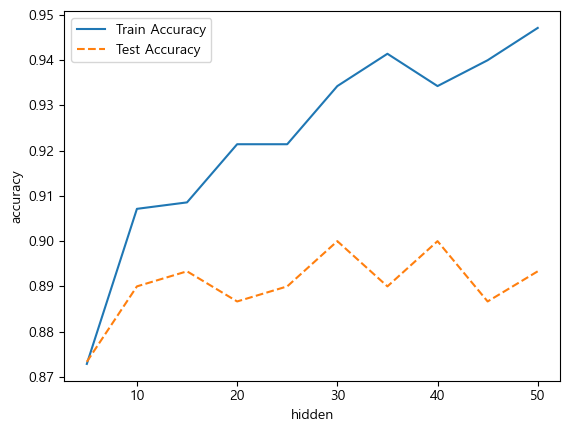

In [404]:
train_accuracy = []; test_accuracy = []
para_hidden=[5*hidden for hidden in range(1,11)]

print(para_hidden)

for v_hidden in para_hidden:
    nn = MLPClassifier(hidden_layer_sizes=v_hidden, random_state=1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["Hidden"] = para_hidden
df_accuracy_hidden["TrainAccuracy"] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy
display(df_accuracy_hidden.round(3))

plt.plot(para_hidden, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("hidden"); plt.ylabel("accuracy")
plt.legend()
plt.show()

,Activation,TrainAccuracy,TestAccuracy
0,logistic,0.864,0.867
1,tanh,0.979,0.890
2,relu,0.989,0.880


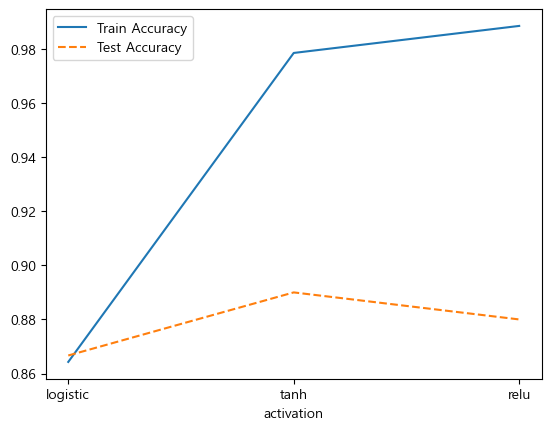

In [405]:
train_accuracy = []; test_accuracy = []
para_activation = ["logistic", "tanh", "relu"]

for v_activation in para_activation:
    nn = MLPClassifier(activation=v_activation, hidden_layer_sizes=(30, 30), random_state=1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_activation = pd.DataFrame()
df_accuracy_activation["Activation"] = para_activation
df_accuracy_activation["TrainAccuracy"] = train_accuracy
df_accuracy_activation["TestAccuracy"] = test_accuracy
display(df_accuracy_activation.round(3))

plt.plot(para_activation, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_activation, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("accuracy"); plt.xlabel("activation")
plt.legend()
plt.show()

,Solver,TrainAccuracy,TestAccuracy
0,lbfgs,1.000,0.87
1,sgd,0.843,0.84
2,adam,0.979,0.89


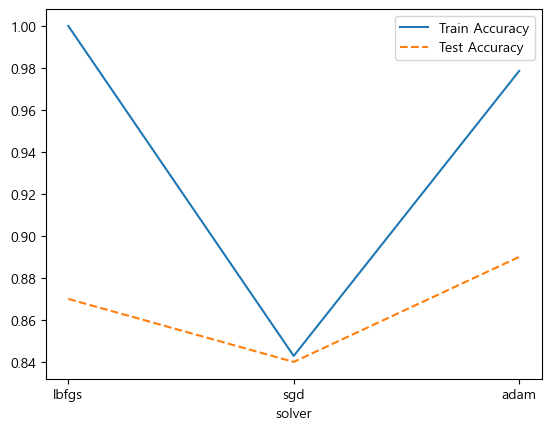

In [406]:
train_accuracy = []; test_accuracy = []
para_solver = ["lbfgs", "sgd", "adam"]

for v_solver in para_solver:
    nn = MLPClassifier(solver=v_solver, hidden_layer_sizes=(30,30), activation='tanh', random_state=1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_solver = pd.DataFrame()
df_accuracy_solver["Solver"] = para_solver
df_accuracy_solver["TrainAccuracy"] = train_accuracy
df_accuracy_solver["TestAccuracy"] = test_accuracy

display(df_accuracy_solver.round(3))

plt.plot(para_solver, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_solver, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("accuracy"); plt.xlabel("solver")
plt.legend()
plt.show()

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]


,Batch,TrainAccuracy,TestAccuracy
0,10,1.000,0.883
1,20,1.000,0.887
2,30,1.000,0.880
3,40,1.000,0.880
4,50,1.000,0.880
5,60,1.000,0.877
6,70,0.999,0.877
7,80,0.997,0.873
8,90,0.996,0.883
9,100,0.994,0.877


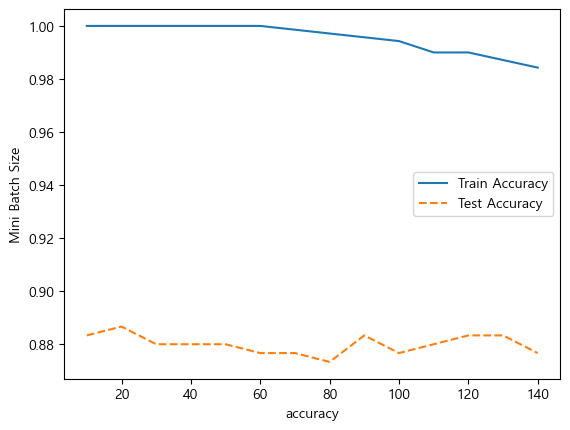

In [407]:
train_accuracy =[]; test_accuracy = []
para_batch=[10*batch for batch in range(1,15)]
print(para_batch)

for v_batch in para_batch:
    nn = MLPClassifier(batch_size=v_batch,
                       solver="adam",
                       activation="tanh",
                       hidden_layer_sizes=(30, 30),
                       random_state=1234)

    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["Batch"] = para_batch
df_accuracy_batch["TrainAccuracy"] = train_accuracy
df_accuracy_batch["TestAccuracy"] = test_accuracy
display(df_accuracy_batch.round(3))

plt.plot(para_batch, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_batch, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("accuracy"); plt.ylabel("Mini Batch Size")
plt.legend()
plt.show()

[0.001, 0.01, 0.1, 1]


,LearningRate,TrainAccuracy,TestAccuracy
0,0.001,0.996,0.883
1,0.010,1.000,0.897
2,0.100,0.966,0.877
3,1.000,0.584,0.560


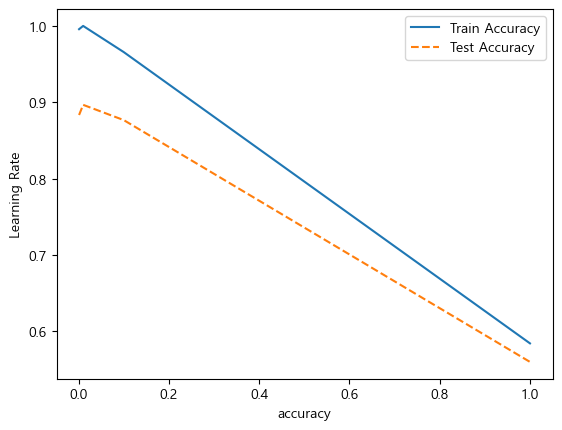

In [408]:
train_accuracy = []; test_accuracy = []

para_lr=[10 ** n for n in range(-3,1)]
print(para_lr)

for v_lr in para_lr:
    nn = MLPClassifier(learning_rate_init=v_lr,
                       batch_size=90,
                       solver="adam",
                       activation="tanh",
                       hidden_layer_sizes=(30, 30),
                       random_state=1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy
display(df_accuracy_lr.round(3))

plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.xlabel("accuracy"); plt.ylabel("Learning Rate")
plt.legend()
plt.show()

#### ✅ nn 최종모델

In [409]:
nn_final=MLPClassifier(hidden_layer_sizes=(30,30),
                        solver="adam",
                        activation="tanh",
                        learning_rate_init=0.01,
                        random_state=1234)
y_pred=nn_final.fit(df_train_x, df_train_y).predict(df_test_x)

print("Train Accuracy: {:.3f}".format(nn_final.score(df_train_x, df_train_y)))
print("Test Accuracy: {:.3f}".format(nn_final.score(df_test_x, df_test_y)))
print("Test Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 1.000
Test Accuracy: 0.883
Test Confusion Matrix: 
[[188  18]
 [ 17  77]]
              precision    recall  f1-score   support

           0      0.917     0.913     0.915       206
           1      0.811     0.819     0.815        94

    accuracy                          0.883       300
   macro avg      0.864     0.866     0.865       300
weighted avg      0.884     0.883     0.884       300



### 교차검증

In [410]:
# from sklearn.model_selection import StratifiedKFold
# S_kfold = StratifiedKFold(n_splits=5, shuffle=True)

# cv_accuracy = []
# n_iter = 0

# x = df_x_converted.values
# y = df['scale'].values

# for train_index, test_index in S_kfold.split(x, y):  
#     x_train, x_test = x[train_index], x[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     xgboost_user.fit(x_train, y_train)
#     pred = xgboost_user.predict(x_test)
#     n_iter += 1
    
#     accuracy = np.round(accuracy_score(y_test, pred), 4) 
#     train_size = x_train.shape[0]
#     test_size = x_test.shape[0]
    
#     print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
#           .format(n_iter, accuracy, train_size, test_size))
#     print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
#     cv_accuracy.append(accuracy)
    
# print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

In [411]:
from sklearn.model_selection import StratifiedKFold

models = [nn_final, svc_final, gb_final, xgboost_user, lightgbm_user, rf_final, tree_final]
results = []

S_kfold = StratifiedKFold(n_splits=5, shuffle=True)

cv_accuracy = []
n_iter = 0

x = df_x_converted.values
y = df['scale'].values

for model in models:
    for train_index, test_index in S_kfold.split(x, y):  
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        n_iter += 1
        
        accuracy = np.round(accuracy_score(y_test, pred), 4) 
        train_size = x_train.shape[0]
        test_size = x_test.shape[0]
        
        # print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
        #       .format(n_iter, accuracy, train_size, test_size))
        # print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,test_index))
        cv_accuracy.append(accuracy)

    results.append(np.mean(cv_accuracy))             
    print(f'\n## {model}의 평균 검증 정확도:', np.mean(cv_accuracy))


## MLPClassifier(activation='tanh', hidden_layer_sizes=(30, 30),
              learning_rate_init=0.01, random_state=1234)의 평균 검증 정확도: 0.9019999999999999

## SVC(C=1.1, gamma=0.1, random_state=1234)의 평균 검증 정확도: 0.8955

## GradientBoostingClassifier(learning_rate=0.04, min_samples_leaf=15,
                           min_samples_split=10, n_estimators=120,
                           random_state=1234)의 평균 검증 정확도: 0.9263333333333332

## XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.22, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
       

※ 전체적으로 과적합 경향이 있어 교차검증을 통해 일반화 가능한 모델인지 파악함

### 모델평가

#### 데이터 분리

In [430]:
df_raw_x = df.drop("scale", axis = 1, inplace = False)
df_raw_y = df["scale"] 

# 범주형 변수 선택 : select_dtypes="object" 
df_raw_x_char = df_raw_x.select_dtypes(include = "object")
df_raw_x_char.head()

# get_dummies: 범주형 변수에 대한 더미변환 
df_x_dummy = pd.get_dummies(df_raw_x_char)

# 연속형 변수 선택 : select_dtypes="object" 제외
df_raw_x_num = df_raw_x.select_dtypes(exclude = "object")
# df_raw_x_num.head()

# 변수명 저장
v_feature_names = df_raw_x_num.columns

# StandardScaler 적용
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_raw_x_num)
df_x_scaled = pd.DataFrame(df_x_scaled, columns=v_feature_names)

df_x_converted = df_x_scaled.join(df_x_dummy)

df_x_raw_dummy = df_raw_x_num.join(df_x_dummy)
df_x_scale_dummy = df_x_scaled.join(df_x_dummy)
df_x_scale_raw = df_x_scaled.join(df_raw_x_char)


df_train_x_rd, df_test_x_rd, df_train_y, df_test_y = train_test_split(df_x_raw_dummy, df_raw_y
                                    , test_size = 0.3, random_state = 1234)
df_train_x_sd, df_test_x_sd, df_train_y, df_test_y = train_test_split(df_x_scale_dummy, df_raw_y
                                    , test_size = 0.3, random_state = 1234)
df_train_x_reg, df_test_x_reg, df_train_y, df_test_y = train_test_split(df_x_scale_raw, df_raw_y
                                    , test_size = 0.3, random_state = 1234)

In [431]:
model = ["DecisionTree", "RandomForest", "GradientBoosting", "SVM", "NeuralNet"]

train_accuracy = []; test_accuracy = []
model_auc = []

model_precision = []; model_recall = []
model_f1_score = []

## @의사결정나무

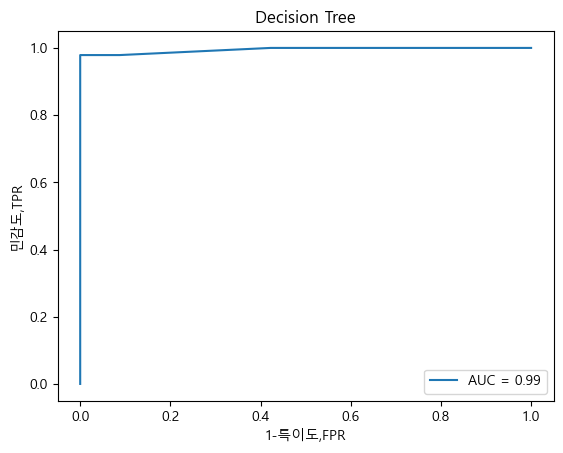

In [432]:
dt_final = DecisionTreeClassifier(max_depth=6, min_samples_leaf=12, random_state=1234)
dt_final.fit(df_train_x_rd, df_train_y)

train_accuracy.append(dt_final.score(df_train_x_rd, df_train_y))
test_accuracy.append(dt_final.score(df_test_x_rd, df_test_y))

y_prob_1 = dt_final.predict_proba(df_test_x_rd)[:, 1]  # 1 발생 확률
y_pred = dt_final.predict(df_test_x_rd)  # 1/0 판정

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)

model_auc.append(roc_auc)

plt.title("Decision Tree")
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("민감도,TPR"); plt.xlabel("1-특이도,FPR") 
plt.show()

In [433]:
model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
model_f1_score.append(f1_score(df_test_y, y_pred))
model_f1_score

[0.989247311827957]

## @랜덤포레스트

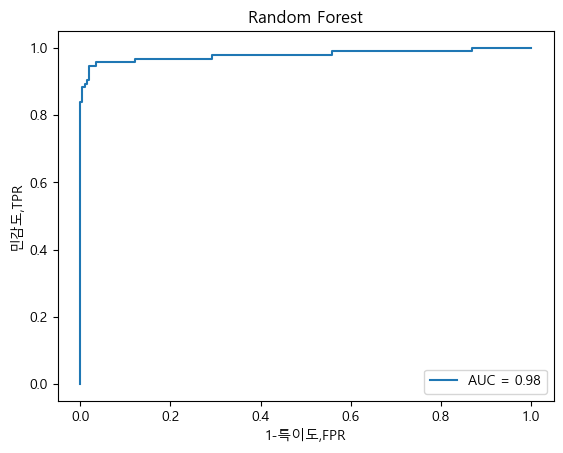

In [434]:
rf_final = RandomForestClassifier(min_samples_leaf=5, max_depth=10, n_estimators=10, min_samples_split=20,
                                  random_state=1234)
rf_final.fit(df_train_x_rd, df_train_y)

train_accuracy.append(rf_final.score(df_train_x_rd, df_train_y))
test_accuracy.append(rf_final.score(df_test_x_rd, df_test_y))

y_prob_1 = rf_final.predict_proba(df_test_x_rd)[:, 1]  # 1 발생 확률
y_pred = rf_final.predict(df_test_x_rd)  # 1/0 판정

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)
model_auc.append(roc_auc)

plt.title("Random Forest")
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("민감도,TPR"); plt.xlabel("1-특이도,FPR") 
plt.show()

In [435]:
model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
model_f1_score.append(f1_score(df_test_y, y_pred))
model_f1_score

[0.989247311827957, 0.9142857142857143]

## @그래디언트 부스팅

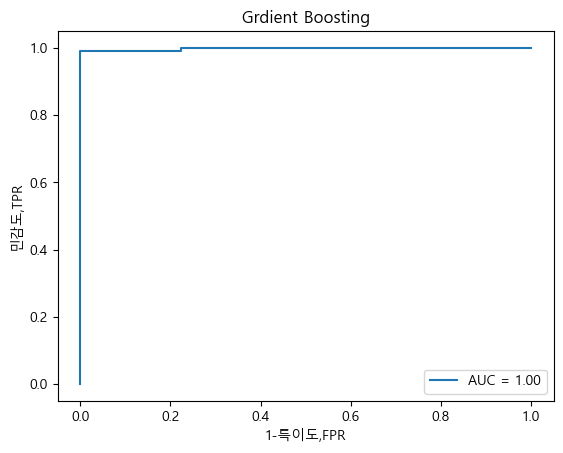

In [436]:
gb_final = GradientBoostingClassifier(min_samples_leaf=15, min_samples_split=10, max_depth=3, n_estimators=120, learning_rate=0.04,
                                      random_state=1234)
gb_final.fit(df_train_x_rd, df_train_y)

train_accuracy.append(gb_final.score(df_train_x_rd, df_train_y))
test_accuracy.append(gb_final.score(df_test_x_rd, df_test_y))

y_prob_1 = gb_final.predict_proba(df_test_x_rd)[:, 1]  # 1 발생 확률
y_pred = gb_final.predict(df_test_x_rd)  # 1/0 판정

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)

model_auc.append(roc_auc)

plt.title("Grdient Boosting")
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("민감도,TPR"); plt.xlabel("1-특이도,FPR") 
plt.show()

In [437]:
model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
model_f1_score.append(f1_score(df_test_y, y_pred))
model_f1_score

[0.989247311827957, 0.9142857142857143, 0.9946524064171123]

## @SVM

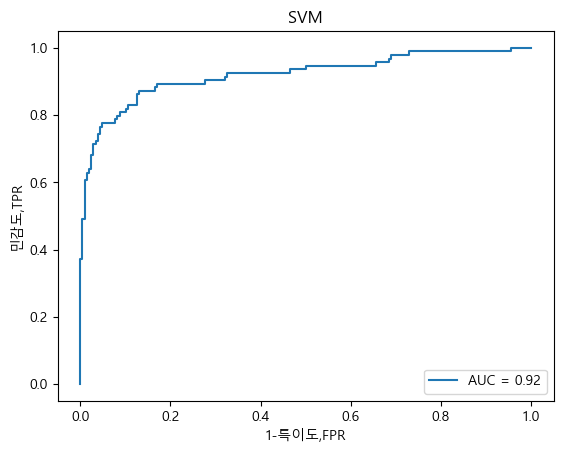

In [438]:
svm = SVC(gamma=0.1, C=1.1, probability=True, random_state=1234)
svm.fit(df_train_x_sd, df_train_y)

train_accuracy.append(svm.score(df_train_x_sd, df_train_y))
test_accuracy.append(svm.score(df_test_x_sd, df_test_y))

y_prob_1 = svm.predict_proba(df_test_x_sd)[:, 1]  # 1 발생 확률
y_pred = svm.predict(df_test_x_sd)  # 1/0 판정

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)

model_auc.append(roc_auc)

plt.title("SVM")
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("민감도,TPR"); plt.xlabel("1-특이도,FPR") 
plt.show()

In [439]:
model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
model_f1_score.append(f1_score(df_test_y, y_pred))
model_f1_score

[0.989247311827957, 0.9142857142857143, 0.9946524064171123, 0.8092485549132948]

## @인공신경망

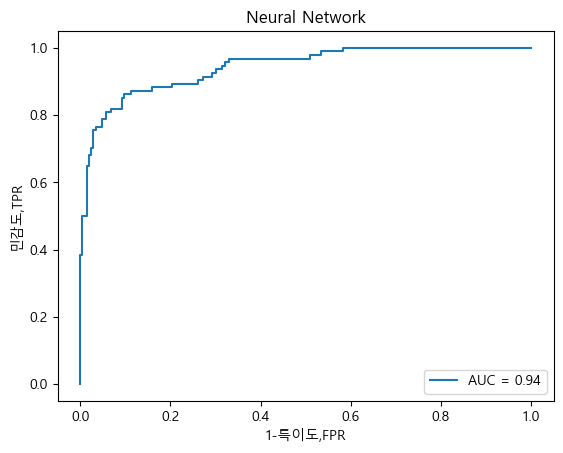

In [440]:
nn_final = MLPClassifier(hidden_layer_sizes=(30,30),
                        solver="adam",
                        activation="tanh",
                        learning_rate_init=0.01,
                        random_state=1234)
nn_final.fit(df_train_x_sd, df_train_y)

train_accuracy.append(nn_final.score(df_train_x_sd, df_train_y))
test_accuracy.append(nn_final.score(df_test_x_sd, df_test_y))

y_prob_1 = nn_final.predict_proba(df_test_x_sd)[:, 1]  # 1 발생 확률
y_pred = nn_final.predict(df_test_x_sd)  # 1/0 판정

fpr, tpr, thresholds = roc_curve(df_test_y, y_prob_1)
roc_auc = auc(fpr, tpr)

model_auc.append(roc_auc)

plt.title("Neural Network")
plt.plot(fpr, tpr, label= "AUC = %0.2f"% roc_auc)
plt.legend(loc="lower right")
plt.ylabel("민감도,TPR"); plt.xlabel("1-특이도,FPR") 
plt.show()

In [441]:
model_precision.append(precision_score(df_test_y, y_pred))
model_recall.append(recall_score(df_test_y, y_pred))
model_f1_score.append(f1_score(df_test_y, y_pred))
model_f1_score

[0.989247311827957,
 0.9142857142857143,
 0.9946524064171123,
 0.8092485549132948,
 0.8148148148148148]

-----------------------------

In [444]:
df_eval

,TrainAccuracy,TestAccuracy,AUC,Precision,Recall,F1Score
DecisionTree,0.980000,0.993333,0.994578,1.000000,0.978723,0.989247
RandomForest,0.947143,0.950000,0.978775,0.987654,0.851064,0.914286
GradientBoosting,0.991429,0.996667,0.997624,1.000000,0.989362,0.994652
SVM,0.931429,0.890000,0.919748,0.886076,0.744681,0.809249
NeuralNet,1.000000,0.883333,0.942625,0.810526,0.819149,0.814815


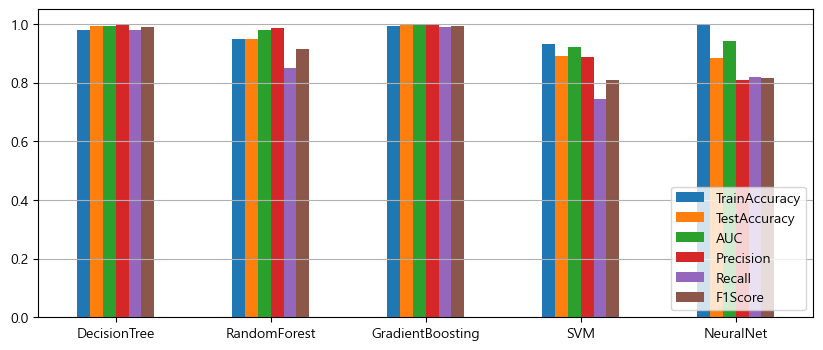

In [443]:
df_eval.plot.bar(rot = 0, figsize=(10,4))
plt.legend(loc="lower right"); plt.grid(axis = "y")

> 결론
- DecisionTree: 테스트 성능은 좋지만, 과적합 가능성 존재
- RandomForest: 훈련, 테스트 둘 다 준수함
- GradientBoosting: 테스트 성능 가장 좋음 -> 일반화 성능 ▲
- SVM: 다른 모델에 비해 테스트 성능이 떨어짐
- NN: 훈련 = 1.0으로 과적합 의심됨

# 파일 내보내기

In [414]:
df_raw_dummy.to_excel('A2_Posco_DataSets.xlsx', index=False)